In [1]:
import os
import sys
import shutil

import logging
import re
import pathlib

import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from pyplink import PyPlink
import seaborn as sns

import statsmodels.api as sm

import matplotlib.patches as patches
import matplotlib

from basic_tools import *

"""

jupyter nbconvert 5_association.ipynb --to script
python 5_association.py albumin 2 0

"""

'\n\njupyter nbconvert 5_association.ipynb --to script\npython 5_association.py albumin 2 0\n\n'

In [2]:
#novelty_check_df.head(100)

In [3]:
plink_KCHIP_HLA_AA_SNP_1000G=PyPlink(plink_KCHIP_HLA_AA_SNP_1000G_path)
plink_KCHIP_HLA_AA_SNP_1000G_fam=plink_KCHIP_HLA_AA_SNP_1000G.get_fam().astype({'fid':str,'iid':str}).rename(columns={'fid':'FID','iid':'IID'})
plink_KCHIP_HLA_AA_SNP_1000G_bim=plink_KCHIP_HLA_AA_SNP_1000G.get_bim()

In [4]:
phenotype_info=pd.read_csv('data/phenotype_pubname.tsv',sep='\t',index_col=0)

In [5]:
phenotypes=pd.read_csv(pheno_all_file_path,sep='\t')
phenotypes=phenotypes.set_index('ID').loc[plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']]

binary_continuous_traits=phenotypes.columns.difference(['age','sex','cohort','diabetes'])
print(len(binary_continuous_traits))

97


In [6]:
result_all[result_all['phenotype_type']=='continuous']['phenotype_name'].unique().shape,\
result_all[result_all['phenotype_type']=='binary']['phenotype_name'].unique().shape,\

NameError: name 'result_all' is not defined

In [6]:
len(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')]['pos'].unique()),\
len(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('AA_')]['pos'].unique()),\
len(plink_KCHIP_HLA_AA_SNP_1000G_bim['pos'].unique())

(8, 349, 67448)

In [7]:
np.unique([i[0] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

array(['HLA_A', 'HLA_B', 'HLA_C', 'HLA_DPA1', 'HLA_DPB1', 'HLA_DQA1',
       'HLA_DQB1', 'HLA_DRB1'], dtype='<U8')

# MAF

In [8]:
def cal_maf(dosage_array):
    maf=(1*(dosage_array==1).sum()+2*(dosage_array==2).sum())/\
         (2*(dosage_array!=-1).sum())
    return maf

maf_list_list=[]
for idx_bim,(SNP,row) in enumerate(plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].iterrows()):
    maf_list=[]
    assert row['a1']=='p'
    dosage=plink_KCHIP_HLA_AA_SNP_1000G.get_geno_marker(SNP)
    maf_list.append(cal_maf(dosage))
    for cohort in range(1,3+1):
        cohort_dosage=dosage[phenotypes['cohort']==cohort]
        #print('total: {:5d} -1:{:5d} 0:{:5d} 1:{:5d} 2:{:5d}'.format(len(cohort_dosage),(cohort_dosage==-1).sum(),(cohort_dosage==0).sum(),(cohort_dosage==1).sum(),(cohort_dosage==2).sum()))
        maf_list.append(cal_maf(cohort_dosage))
    
    maf_list_list.append(maf_list)

In [9]:
assert (phenotypes.index!=plink_KCHIP_HLA_AA_SNP_1000G_fam['IID']).sum()==0

In [10]:
maf_df=pd.DataFrame(maf_list_list,index=plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index,columns=['all','AS','CT','NC'])

In [11]:
maf_df.index=maf_df.index.str.replace('_','-')

In [12]:
maf_df.to_csv(data_out_pub_path+'HLA_allele_freq.tsv',sep='\t')

In [13]:
gene_bed_path='data/mart_export_grch37.txt'
gene_bed=pd.read_csv(gene_bed_path,sep='\t')
gene_bed=gene_bed.drop(columns='Exon stable ID')
gene_bed=gene_bed[(gene_bed['Gene start (bp)']>=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min())&(gene_bed['Gene end (bp)']<=plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]
gene_bed=gene_bed.merge(right=pd.read_csv('data/mart_export_grch38.txt',sep='\t')[['Gene stable ID','Gene start (bp)','Gene end (bp)']].rename(columns=(lambda x:x+'38')),left_on='Gene stable ID',right_on='Gene stable ID38',how='left',)

gene_bed=gene_bed[(gene_bed['Transcript type']=='protein_coding')]
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name','Gene start (bp)','Gene end (bp)'])]
print(gene_bed.shape)
gene_bed=gene_bed[~gene_bed.duplicated(['Gene name'])]
print(gene_bed.shape)

print(gene_bed.shape)

gene_assign=plink_KCHIP_HLA_AA_SNP_1000G_bim[['pos']]

for idx,row in gene_bed.iterrows():
    gene_assign[row['Gene name']]=0
    
for idx,row in gene_bed.iterrows():    
    gene_assign[row['Gene name']][(gene_assign['pos']>=row['Gene start (bp)'])&(gene_assign['pos']<=row['Gene end (bp)'])]=1

#gene_assign.columns=gene_assign.columns.str.replace('HLA-','HLA_')        
    
HLA_names=np.unique([i[0].split('_')[1] for i in plink_KCHIP_HLA_AA_SNP_1000G_bim[plink_KCHIP_HLA_AA_SNP_1000G_bim.index.str.contains('HLA_')].index.str.split('*')])

for HLA_name in HLA_names:
    gene_select=gene_assign[gene_assign.index.str.contains('HLA_'+HLA_name)|gene_assign.index.str.contains('SNPS_'+HLA_name)|gene_assign.index.str.contains('AA_'+HLA_name)]#print(gene_select.sort_values('pos').iloc[0],gene_select.sort_values('pos').iloc[-1])
    HLA_name='HLA-{}'.format(HLA_name)
    gene_assign[HLA_name][(gene_assign['pos']>=gene_select['pos'].min())&(gene_assign['pos']<=gene_select['pos'].max())]=1 

(209, 33)
(207, 33)
(207, 33)


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Pub GWAS per phenotype

In [12]:
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    
    pheotype_name_publication=phenotype_info.loc[phenotype_name]['phenotype_name_publication'].replace(' ','_').replace('/','_')
    
    data_out_pub_phenotype_path=data_out_pub_path+pheotype_name_publication+'/'
    pathlib.Path(data_out_pub_phenotype_path).mkdir(parents=True, exist_ok=True)
    
    
    
    #pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    #phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
    #phenotype_type    
    
    for step_idx_sub in range(1,100):
        print("phenotype_name: {}, phenotype_type:{} , Step : {} ".format(phenotype_name,'  ',step_idx_sub))
        #print(step_idx_sub)
        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
            print('meets end',step_idx_sub)
            break
            
        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t',index_col=0)
        result_merge=result_merge.drop(columns=['phenotype_name'])  
        result_merge['phenotype_name_publication']=phenotype_info.loc[phenotype_name]['phenotype_name_publication']
        #print(result_merge.columns)
        
        result_merge[['phenotype_name_publication','phenotype_type', 'samples(case/control)', 'step', 'condition',
               'marker_name', 'marker_name_pub', 'note', 'term', 'POS', 'A1', 'A2',
               'A1_freq_case', 'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef',
               'std', 'chisq', 'df', 'P']].to_csv(data_out_pub_phenotype_path+'step_{:02d}.result.tsv'.format(step_idx_sub),sep='\t',index=None)        
        
        shutil.copy(data_out_assoc_phenotype_path+'step_{:02d}.merge.manhattan.png'.format(step_idx_sub),
                    data_out_pub_phenotype_path+'step_{:02d}.manhattan.png'.format(step_idx_sub))         
        
        
        #break
    #break
        

phenotype_name: FEV_over_FVC_predicted, phenotype_type:   , Step : 1 


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


phenotype_name: FEV_over_FVC_predicted, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: FEV_predicted, phenotype_type:   , Step : 1 
phenotype_name: FEV_predicted, phenotype_type:   , Step : 2 
phenotype_name: FEV_predicted, phenotype_type:   , Step : 3 
meets end 3
phenotype_name: FVC_predicted, phenotype_type:   , Step : 1 
phenotype_name: FVC_predicted, phenotype_type:   , Step : 2 
phenotype_name: FVC_predicted, phenotype_type:   , Step : 3 
meets end 3
phenotype_name: MVV_predicted, phenotype_type:   , Step : 1 
phenotype_name: MVV_predicted, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: acute_liver_disease, phenotype_type:   , Step : 1 
phenotype_name: acute_liver_disease, phenotype_type:   , Step : 2 
meets end 2
phenotype_name: albumin, phenotype_type:   , Step : 1 
phenotype_name: albumin, phenotype_type:   , Step : 2 
phenotype_name: albumin, phenotype_type:   , Step : 3 
phenotype_name: albumin, phenotype_type:   , Step : 4 
phenotype_name: albumin, phe

# Pub GWAS all phenotypes

In [61]:
result_all=pd.read_csv('data/result_concat_2_top_gene_annot.tsv',sep='\t',index_col=1)

In [62]:
result_all_pub=result_all.copy()

In [63]:
result_all_pub=result_all_pub[(result_all_pub['P_significant']==1)]

In [64]:
result_all_pub['phenotype_category']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_category'].values
result_all_pub['phenotype_name_publication']=phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_name_publication'].values

assert np.all(result_all_pub['phenotype_type']==phenotype_info.loc[result_all_pub['phenotype_name']]['phenotype_type'].values)

In [65]:
result_all_pub['A1 freq (cases, controls)']=result_all_pub.apply(lambda x: '{:.3f}, {:.3f}'.format(x['A1_freq_case'],x['A1_freq_control']).replace(', nan','').replace('nan','-'), axis=1)

In [66]:
def marker_name_pub_prettify(marker_name_pub):
    if 'rs' in marker_name_pub:
        return marker_name_pub
    elif 'HLA' in marker_name_pub:
        return marker_name_pub
    elif '6:' in marker_name_pub:
        return marker_name_pub.split('_')[0]
    elif 'SNP' in marker_name_pub:
        return '6:'+marker_name_pub.split('_')[3]
    else:
        raise
#result_all_pub.apply(lambda x: x['marker_name_pub'] if 'rs' in x['marker_name_pub'] else ('aaaa',x['marker_name_pub']), axis=1)
result_all_pub['marker_name_pub_prettify']=result_all_pub['marker_name_pub'].apply(marker_name_pub_prettify)

In [67]:
#result_all_pub['marker_name_pub']

In [68]:
result_all_pub['A1/A2']=result_all_pub.apply(lambda x: '{}/{}'.format(x['A1'],x['A2']).replace('/nan','').replace('nan','-').replace('p/a','-').replace('a/p','-'), axis=1)

In [69]:
result_all_pub['genehow_prettify']=result_all_pub['genehow'].str.replace('_',' ')

In [70]:
result_all_pub['coef (std)']=result_all_pub.apply(lambda x: '{:.3f} ({:.4f})'.format(x['coef'],x['std']).replace('nan (nan)','-'), axis=1)

In [71]:
result_all_pub.columns

Index(['Unnamed: 0', 'phenotype_type', 'phenotype_name',
       'samples(case/control)', 'step', 'condition', 'marker_name',
       'marker_name_pub', 'note', 'term', 'POS', 'A1', 'A2', 'A1_freq_case',
       'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef', 'std', 'chisq',
       'df', 'P', 'P_significant', 'gene_genehow', 'gene', 'genehow',
       'phenotype_category', 'phenotype_name_publication',
       'A1 freq (cases, controls)', 'marker_name_pub_prettify', 'A1/A2',
       'genehow_prettify', 'coef (std)'],
      dtype='object')

In [72]:
#result_all_pub[result_all_pub['marker_name_pub'].str.contains('pos')]

In [73]:
result_all_pub[['phenotype_type','phenotype_category', 'phenotype_name_publication','samples(case/control)',
                                    'marker_name_pub_prettify', 'POS', 'A1/A2','gene','genehow_prettify' ,'A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_all.tsv',sep='\t')

In [114]:
result_all_pub.columns

Index(['Unnamed: 0', 'phenotype_type', 'phenotype_name',
       'samples(case/control)', 'step', 'condition', 'marker_name',
       'marker_name_pub', 'note', 'term', 'POS', 'A1', 'A2', 'A1_freq_case',
       'A1_freq_control', 'multi_allele', 'nobs', 'Z', 'coef', 'std', 'chisq',
       'df', 'P', 'P_significant', 'gene_genehow', 'gene', 'genehow',
       'phenotype_category', 'phenotype_name_publication',
       'A1 freq (cases, controls)', 'marker_name_pub_prettify', 'A1/A2',
       'genehow_prettify', 'coef (std)'],
      dtype='object')

In [115]:
result_all_pub[['phenotype_type','phenotype_category', 'phenotype_name', 'phenotype_name_publication','samples(case/control)','condition',
                                    'marker_name_pub_prettify', 'POS', 'A1/A2','gene', 'genehow_prettify','A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_all_temp.tsv',sep='\t')

In [75]:
result_all_pub[result_all_pub['step']==1][['phenotype_type','phenotype_category', 'phenotype_name_publication','samples(case/control)',
                                    'marker_name_pub_prettify', 'POS', 'A1/A2','gene','genehow_prettify' , 'A1 freq (cases, controls)', 'coef (std)', 'P']]\
.rename(columns={'phenotype_name_publication':'Phenotype',
                 'samples(case/control)':'N (case/control)',
                 'marker_name_pub_prettify':'Variant',
                 'POS':'Position',
                 'gene':'Gene'}).sort_values(['phenotype_type','phenotype_category']).to_csv(data_out_pub_path+'GWAS_top_step1.tsv',sep='\t')

# HLA omnibus

In [76]:
assoc_result_list=[]
for phenotype_name in binary_continuous_traits:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'

    for step_idx_sub in range(1,100):
        #print(step_idx_sub)
        if os.path.exists(data_out_assoc_phenotype_path+'step_{:02d}.cond.stop'.format(step_idx_sub)):
            print('meets end',step_idx_sub)
            break
        result_merge=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.merge.result.tsv'.format(step_idx_sub),sep='\t')
        break#assoc_result_list.append(result_merge.sort_values('P').iloc[0])
    break

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
HLA_result_list=[]
for phenotype_name in binary_continuous_traits[:]:
    data_out_assoc_phenotype_path=data_out_assoc_path+phenotype_name+'/'
    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',names=['FID','IID','pheno'])
    
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'    
    print(phenotype_name,phenotype_type)

    step_idx_sub=1

    GAT_result=pd.read_csv(data_out_assoc_phenotype_path+'step_{:02d}.GAT.result.tsv'.format(step_idx_sub),sep='\t')
    GAT_result=GAT_result[(GAT_result['marker_name'].str.contains('HLA',regex=False))&(~GAT_result['marker_name'].str.contains('*',regex=False))]
    GAT_result['phenotype_name']=phenotype_name
    HLA_result_list.append(GAT_result[['phenotype_name','marker_name','P']])

FEV_over_FVC_predicted continuous
FEV_predicted continuous
FVC_predicted continuous
MVV_predicted continuous
acute_liver_disease binary
albumin continuous
allergic_disease binary
alt continuous
angina_pectoris_myocardial_infarction binary
arthritis binary
ast continuous
asthma binary
benign_prostatic_hyperplasia binary
big_baby binary
bladder_cancer binary
blood_in_urine binary
bmi continuous
bone_density_distal_sos continuous
bone_density_midshaft_sos continuous
breast_cancer binary
bun continuous
cataract binary
cervical_cancer binary
child_dead continuous
child_delivery_number continuous
child_present continuous
cholelithiasis_cholecystitis binary
chronic_bronchitis binary
chronic_gastritis_stomach_ulcer binary
colon_polyps binary
colorectal_cancer binary
copd binary
creatinine continuous
diastolic_blood_pressure continuous
duodenal_ulcer binary
fatty_liver binary
fracture binary
freet4 continuous
glaucoma binary
glucose_in_urine binary
gout binary
grip_strength continuous
gtp conti

In [78]:
HLA_result_heatmap=pd.concat(HLA_result_list).pivot(columns='marker_name',index='phenotype_name',values='P')

In [79]:
HLA_result_heatmap.columns=HLA_result_heatmap.columns.str.replace('_','-')

In [80]:
HLA_result_heatmap=HLA_result_heatmap[gene_bed.set_index('Gene name').loc[HLA_result_heatmap.columns].sort_values('Gene start (bp)').index]

In [81]:
HLA_result_heatmap=HLA_result_heatmap.loc[phenotype_info.loc[HLA_result_heatmap.index].sort_values(['phenotype_type','phenotype_category']).index]

In [82]:
HLA_result_heatmap_significant=HLA_result_heatmap[HLA_result_heatmap.min(axis=1)<(5e-8)]
HLA_result_heatmap_significant=HLA_result_heatmap_significant[HLA_result_heatmap_significant<5e-8].applymap(lambda x: -np.log10(x))
#.applymap(lambda x: -np.log10(x))

In [83]:
def DiscretePalette(n, palette=None):
    palettes={
                'alphabet':[
                  "#F0A0FF", "#0075DC", "#993F00", "#4C005C", "#191919", "#005C31",
                  "#2BCE48", "#FFCC99", "#808080", "#94FFB5", "#8F7C00", "#9DCC00",
                  "#C20088", "#003380", "#FFA405", "#FFA8BB", "#426600", "#FF0010",
                  "#5EF1F2", "#00998F", "#E0FF66", "#740AFF", "#990000", "#FFFF80",
                  "#FFE100", "#FF5005"
                ],
                'alphabet2':[
                  "#AA0DFE", "#3283FE", "#85660D", "#782AB6", "#565656", "#1C8356",
                  "#16FF32", "#F7E1A0", "#E2E2E2", "#1CBE4F", "#C4451C", "#DEA0FD",
                  "#FE00FA", "#325A9B", "#FEAF16", "#F8A19F", "#90AD1C", "#F6222E",
                  "#1CFFCE", "#2ED9FF", "#B10DA1", "#C075A6", "#FC1CBF", "#B00068",
                  "#FBE426", "#FA0087"
                ],
                'glasbey':[
                  "#0000FF", "#FF0000", "#00FF00", "#000033", "#FF00B6", "#005300",
                  "#FFD300", "#009FFF", "#9A4D42", "#00FFBE", "#783FC1", "#1F9698",
                  "#FFACFD", "#B1CC71", "#F1085C", "#FE8F42", "#DD00FF", "#201A01",
                  "#720055", "#766C95", "#02AD24", "#C8FF00", "#886C00", "#FFB79F",
                  "#858567", "#A10300", "#14F9FF", "#00479E", "#DC5E93", "#93D4FF",
                  "#004CFF", "#F2F318"
                ],
                'polychrome':[
                  "#5A5156", "#E4E1E3", "#F6222E", "#FE00FA", "#16FF32", "#3283FE",
                  "#FEAF16", "#B00068", "#1CFFCE", "#90AD1C", "#2ED9FF", "#DEA0FD",
                  "#AA0DFE", "#F8A19F", "#325A9B", "#C4451C", "#1C8356", "#85660D",
                  "#B10DA1", "#FBE426", "#1CBE4F", "#FA0087", "#FC1CBF", "#F7E1A0",
                  "#C075A6", "#782AB6", "#AAF400", "#BDCDFF", "#822E1C", "#B5EFB5",
                  "#7ED7D1", "#1C7F93", "#D85FF7", "#683B79", "#66B0FF", "#3B00FB"
                ],
                'stepped':[
                  "#990F26", "#B33E52", "#CC7A88", "#E6B8BF", "#99600F", "#B3823E",
                  "#CCAA7A", "#E6D2B8", "#54990F", "#78B33E", "#A3CC7A", "#CFE6B8",
                  "#0F8299", "#3E9FB3", "#7ABECC", "#B8DEE6", "#3D0F99", "#653EB3",
                  "#967ACC", "#C7B8E6", "#333333", "#666666", "#999999", "#CCCCCC"
                ]
            }
    if palette is None:
        if n<=26:
            palette="alphabet"
        elif n<=32:
            palette="glasbey"
        else:
            palette="polychrome"
    
    palette_array= palettes[palette]
    #print(len(palette_array))
    assert n<=len(palette_array), "Not enough colours in specified palette"

    return np.array(palette_array)[np.arange(n)]

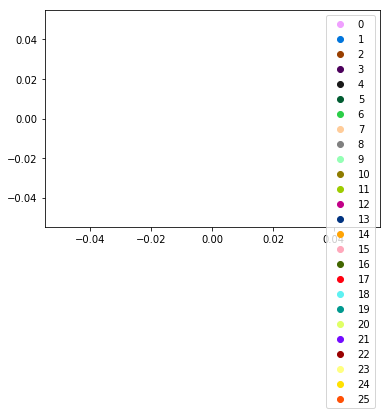

In [84]:
color_list=DiscretePalette(26)
for idx,color in enumerate(color_list):
    plt.scatter([],[],c=color,label=idx)
plt.legend()
#plt.sca
#pd.DataFrame({'color':color_list,
#             'x':np.arange(len(color_list))
#             }).plot.scatter(x='x',y='x',c='color')

In [85]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt

rgba_array=[(190,235,256,256),
            (110,150,220,256),
            (26,42,180,256),
            (30,128,30,256),
            (249,206,20,256),
            (231,51,132,256)]
cutidx_array=np.array([160,330,500,667,830,1000])

custom_cmap_array=[]

for idx in range(1000):
    custom_cmap_array.append(
        rgba_array[np.argmax((cutidx_array-idx)>0)]
    )
    
custom_cmap_array=np.array(custom_cmap_array)/256
print(custom_cmap_array.shape)

custom_cmap = ListedColormap(custom_cmap_array)

(1000, 4)


In [86]:
from PIL import ImageColor

color_list=DiscretePalette(26)

def category_to_color_category(category,mode='color'):
    color=(0,0,0,256)
    if 'Hemato' in category:##
        #color=(180,5,5,256)
        color=ImageColor.getcolor(color_list[17], "RGBA")
    elif 'Anthropomet' in category:##
        #color=(5,5,180,256)
        color=ImageColor.getcolor(color_list[1], "RGBA")
    elif 'Protein' in category:##
        #color=(5,180,5,256)        
        color=ImageColor.getcolor(color_list[2], "RGBA")
    elif 'Metabolic' in category:##
        #color=(160,120,20,256)
        color=ImageColor.getcolor(color_list[3], "RGBA")
    elif 'Liver' in category:
        #color=(120,20,160,256)
        color=ImageColor.getcolor(color_list[14], "RGBA")
    elif 'Kidney' in category:##
        #color=(20,120,160,256)
        color=ImageColor.getcolor(color_list[5], "RGBA")
    elif 'Blood-pressure' in category:
        #color=(256,50,5,256)
        color=ImageColor.getcolor(color_list[6], "RGBA")
    elif 'Cardio' in category:
        color=ImageColor.getcolor(color_list[12], "RGBA")
        pass
    elif 'Thyr' in category:
        color=ImageColor.getcolor(color_list[10], "RGBA")
    elif 'Immune' in category:
        color=ImageColor.getcolor(color_list[21], "RGBA")
    elif 'Nervou' in category:
        color=ImageColor.getcolor(color_list[22], "RGBA")
    elif 'Orth' in category:
        color=ImageColor.getcolor(color_list[25], "RGBA")
        
    elif 'Canc' in category:
        color=ImageColor.getcolor(color_list[16], "RGBA")
    elif 'Eye' in category:
        color=ImageColor.getcolor(color_list[11], "RGBA")
        
    if mode=='color':
        return np.array(color)/256
    else:
        return category.replace(' disease','').replace(' QTL','')
    

In [87]:
def gene_to_color_category(gene_name,mode='color'):
    if gene_name in ['HLA-A','HLA-B','HLA-C']:
        #color='#fa3c14'
        #250, 58, 20
        color=1/256*np.array((250,58,20,256))
        category='Classical HLA gene (class I)'
    elif gene_name in ['HLA-DPA1', 'HLA-DPB1','HLA-DQA1', 'HLA-DQB1','HLA-DRB1','HLA-DRA']:
        #color='#2850c8'
        color=1/256*np.array((40, 80, 200,256))
        category='Classical HLA gene (class II)'
    elif gene_name in ['HLA-F', 'HLA-G', 'HLA-E', 'HLA-DRB5', 'HLA-DQA2', 'HLA-DQB2', 'HLA-DOB', 'HLA-DMB', 'HLA-DMA', 'HLA-DOA', 'MICA','MICB','TAP2','TAP1']:
        #color='#28c828'
        color=1/256*np.array((40, 200, 40,256))
        category='Nonclassical HLA gene'
    else:
        #color='#fafac8'
        color=1/256*np.array((250, 250, 200,256))
        color[:3]=color[:3]*0.1
        color=1/256*np.array((0, 0, 0,256))
        category='Other genes'
    if mode=='color':
        return color
    elif mode=='category':
        return category

In [88]:
dftemp=pd.DataFrame(index=HLA_result_heatmap_significant.columns)
dftemp['color']=HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'color'))
dftemp['category']=HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'category'))
dftemp['x']=np.arange(len(dftemp))

In [89]:
dftemp

,color,category,x
marker_name,,,
HLA-A,"[0.9765625, 0.2265625, 0.078125, 1.0]",Classical HLA gene (class I),0
HLA-C,"[0.9765625, 0.2265625, 0.078125, 1.0]",Classical HLA gene (class I),1
HLA-B,"[0.9765625, 0.2265625, 0.078125, 1.0]",Classical HLA gene (class I),2
HLA-DRB1,"[0.15625, 0.3125, 0.78125, 1.0]",Classical HLA gene (class II),3
HLA-DQA1,"[0.15625, 0.3125, 0.78125, 1.0]",Classical HLA gene (class II),4
HLA-DQB1,"[0.15625, 0.3125, 0.78125, 1.0]",Classical HLA gene (class II),5
HLA-DPA1,"[0.15625, 0.3125, 0.78125, 1.0]",Classical HLA gene (class II),6
HLA-DPB1,"[0.15625, 0.3125, 0.78125, 1.0]",Classical HLA gene (class II),7


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

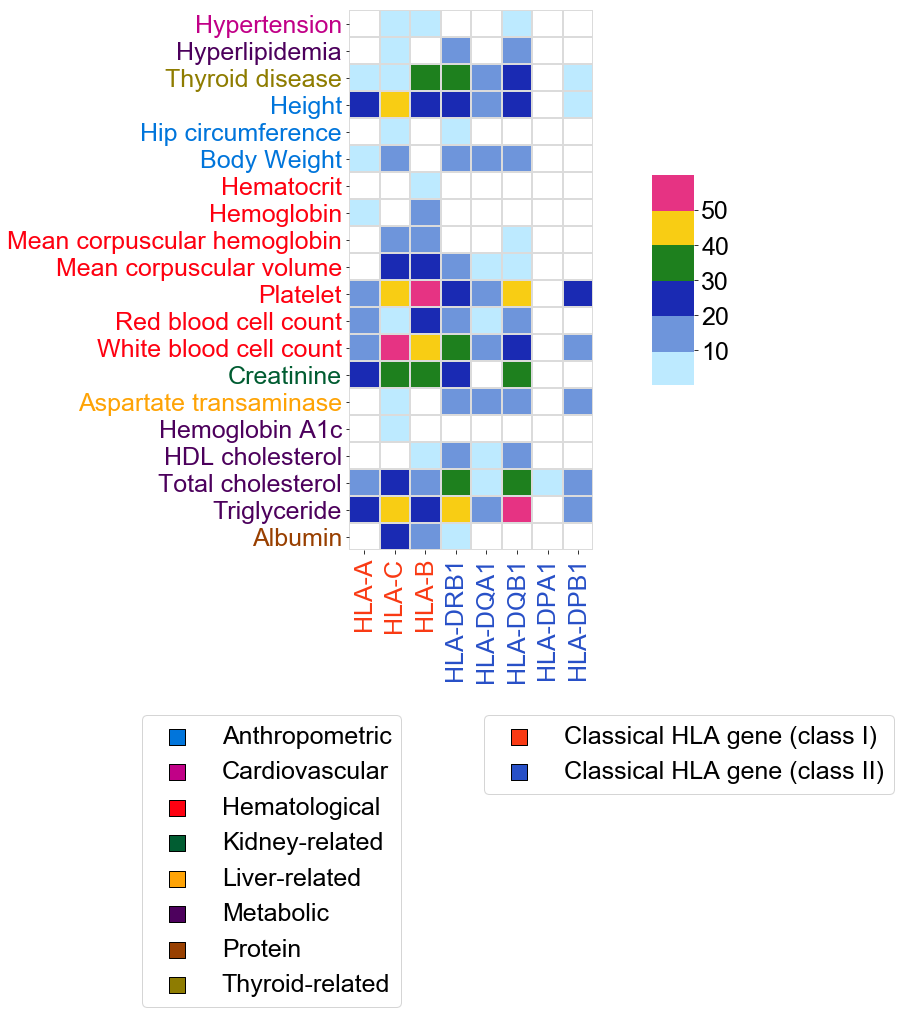

In [90]:
plt.rcParams['font.family']='Arial'
plt.rcParams["font.size"] = 25


import matplotlib.gridspec as gridspec
import seaborn as sns


fig = plt.figure(figsize=(5+1+2, 10+3+4)) 


gs=fig.add_gridspec(10+3+4,5+1+3)

fig_heatmap=fig.add_subplot(gs[0:10,0:5])
fig_heatmap_cmap=fig.add_subplot(gs[0+3:10-3, 5+1:5+1+1])

sns.heatmap(HLA_result_heatmap_significant,
            ax=fig_heatmap,
            cmap=custom_cmap,
            vmin=0,
            vmax=60,
            linewidths=1,
            linecolor=np.array([220,220,220,256])/256,
            cbar_ax=fig_heatmap_cmap,
            cbar_kws={'fraction':0.1, "ticks":[10, 20, 30, 40, 50]},
            cbar=True,
            alpha=1,edgecolor='black')

fig_heatmap.set_ylabel('')
fig_heatmap.set_xlabel('')

for ticklabel in fig_heatmap.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))
fig_heatmap.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_heatmap.get_yticklabels()])


for ticklabel in fig_heatmap.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color_category(gene_name,'color'))
    

fig_legend=fig.add_subplot(gs[10+3:10+3+4, 0:5])


category_color_df=pd.DataFrame([phenotype_info.loc[HLA_result_heatmap_significant.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[HLA_result_heatmap_significant.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(-0.9, 1.1)
    
)

#print(category_color_df.head())
fig_legend.axis("off")
category_color_df=pd.DataFrame([HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'category')),
                            HLA_result_heatmap_significant.columns.map(lambda x: gene_to_color_category(x,'color')),
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend2=fig_legend.legend(
                    [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                    [row['category'] for (idx,row) in category_color_df.iterrows()],
                   loc='upper left',bbox_to_anchor=(0.5, 1.1)
    
)


#print(category_color_df.head())
plt.gca().add_artist(legend1)
fig_legend.axis("off")
#fig_legend.legend()

plt.style.use('default')

plt.savefig(data_out_pub_path+'HLA_omnibus.png', bbox_inches='tight')
  

# Novelty check

## Just run one time

In [29]:
catalog_grch38=pd.read_csv('data/gwas_catalog_v1.0.2-associations_e100_r2020-09-09.tsv',sep='\t')
catalog_grch38_chr6=catalog_grch38[catalog_grch38['CHR_ID']=='6']
catalog_grch38_chr6['CHR_POS']=catalog_grch38_chr6['CHR_POS'].astype(int)
catalog_grch38_chr6=catalog_grch38_chr6[(catalog_grch38_chr6['CHR_POS']!=118883461)]

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,11,12,13,23,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
catalog_grch38_chr6.shape

(15452, 38)

In [31]:
('chr6:'+catalog_grch38_chr6['CHR_POS'].astype(str)+'-'+catalog_grch38_chr6['CHR_POS'].astype(str)).to_csv('data/gwas_catalog_v1.0.2-associations_e100_r2020-09-09_POS_grch38.tsv',sep='\t',index=None,header=False)

# UCSC lift over
https://genome.ucsc.edu/cgi-bin/hgLiftOver

In [32]:
new_pos=pd.read_csv('data/hglft_genome_38d30_f57940.bed',sep='[a-z:-]',names=['','','CHR_ID','CHR_POS','CHR_POS'])['CHR_POS'].values

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [33]:
catalog_grch38_chr6['CHR_POS']=new_pos

In [34]:
catalog_grch38_chr6.to_csv('data/gwas_catalog_v1.0.2-associations_e100_r2020-09-09_grch37.tsv',sep='\t')

In [82]:
type(catalog_grch37["CHR_ID"].iloc[0])

NameError: name 'catalog_grch37' is not defined

In [35]:
catalog_grch37=pd.read_csv('data/gwas_catalog_v1.0.2-associations_e100_r2020-09-09_grch37.tsv',sep='\t',index_col=0)
catalog_grch37['DISEASE/TRAIT']=catalog_grch37['DISEASE/TRAIT'].str.lower()
catalog_grch37['MAPPED_TRAIT']=catalog_grch37['MAPPED_TRAIT'].str.lower()
catalog_grch37['CHR_ID']=catalog_grch37['CHR_ID'].astype(int)
catalog_grch37['CHR_POS']=catalog_grch37['CHR_POS'].astype(int)

catalog_chr6_grch37=catalog_grch37[catalog_grch37['CHR_ID']==6]
assert len(catalog_chr6_grch37)==len(catalog_grch37)

catalog_chr6_grch37.columns

catalog_chr6_short=catalog_chr6_grch37.drop(columns=['DATE ADDED TO CATALOG','REPLICATION SAMPLE SIZE','DATE','REGION','FIRST AUTHOR','JOURNAL','CHR_ID','LINK','MERGED','RISK ALLELE FREQUENCY','PVALUE_MLOG','STRONGEST SNP-RISK ALLELE','95% CI (TEXT)','OR or BETA','PLATFORM [SNPS PASSING QC]','MAPPED_TRAIT_URI','GENOTYPING TECHNOLOGY','STUDY ACCESSION'])
catalog_chr6_short=catalog_chr6_short[(catalog_chr6_short['CHR_POS'].astype(int)>plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.min()) & (catalog_chr6_short['CHR_POS']<plink_KCHIP_HLA_AA_SNP_1000G_bim.pos.max())]

len(catalog_chr6_short['DISEASE/TRAIT'].unique()),len(catalog_chr6_short['MAPPED_TRAIT'].unique())

catalog_chr6_short=catalog_chr6_short[catalog_chr6_short['P-VALUE'].astype(float)<5e-8]

japan_data=pd.read_csv('data/japan.tsv',sep='\t',index_col=0)
japan_data['DISEASE/TRAIT']=japan_data['DISEASE/TRAIT'].str.lower()
catalog_chr6_short=pd.concat([catalog_chr6_short,japan_data])

#catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']==30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']==30692682)].map(lambda x: pos_to_gene(x,mode='37'))    

#catalog_chr6_short[(catalog_chr6_short['PUBMEDID']==30692682)]#['GENE_CUSTOM']

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [36]:
#gene_bed

In [37]:
#japan_data.sort_values('P-VALUE')

In [40]:
#catalog_chr6_short[['SNPS','CHR_POS']]

In [ ]:
def pos_to_gene(pos,mode='38'):
    if mode=='38':
        start='Gene start (bp)38'
        end='Gene end (bp)38'
    elif mode=='37':
        start='Gene start (bp)'
        end='Gene end (bp)'    
    else:
        raise
        
    gene_bed_select=gene_bed[(gene_bed[start]<pos) & (pos<gene_bed[end])]
    if gene_bed_select.shape[0]>0:
        return ','.join(gene_bed_select['Gene name'])
    
    front_back=[]
    gene_bed_select=gene_bed[gene_bed[end]<pos]
    gene_bed_select.loc[:,'dist']=(gene_bed_select[end]-pos).abs()
    if gene_bed_select.shape[0]>0:
        front_back.append(gene_bed_select.sort_values('dist')['Gene name'].iloc[0])
    
    gene_bed_select=gene_bed[gene_bed[start]>pos]
    gene_bed_select.loc[:,'dist']=(gene_bed_select[start]-pos).abs()
    if gene_bed_select.shape[0]>0:
        front_back.append(gene_bed_select.sort_values('dist')['Gene name'].iloc[0])
        
    return ','.join(front_back)

catalog_chr6_short['GENE_CUSTOM']=np.nan
#catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']!=30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']!=30692682)].map(lambda x: pos_to_gene(x,mode='38'))    
#catalog_chr6_short['GENE_CUSTOM'][(catalog_chr6_short['PUBMEDID']==30692682)]=catalog_chr6_short['CHR_POS'][(catalog_chr6_short['PUBMEDID']==30692682)].map(lambda x: pos_to_gene(x,mode='37'))    
catalog_chr6_short['GENE_CUSTOM']=catalog_chr6_short['CHR_POS'].map(lambda x: pos_to_gene(x,mode='37'))    

In [42]:
gene_unique=gene_bed['Gene name'].unique()
def gene_bed_match(gene):
    if type(gene)==float:
        return ''
    gene_list=[i.strip() for i in gene.split(',')]
    return ','.join(list(filter(lambda x: x in gene_unique,gene_list)))
    
catalog_chr6_short['REPORTED_GENE_CUSTOM']=catalog_chr6_short['REPORTED GENE(S)'].map(gene_bed_match)
catalog_chr6_short['GENE_CUSTOM_REPORTED_GENE_CUSTOM']=catalog_chr6_short[['GENE_CUSTOM','REPORTED_GENE_CUSTOM']].apply(lambda x: np.unique((x[0]+','+x[1]).strip(',').split(',')),axis=1)

In [45]:
#catalog_chr6_short.to_csv('data/gwas_catalog_v1.0.2-associations_e100_r2020-09-09_grch37_munged.tsv',sep='\t')

In [46]:
catalog_chr6_short=pd.read_csv('data/gwas_catalog_v1.0.2-associations_e100_r2020-09-09_grch37_munged.tsv',sep='\t',index_col=0)

In [48]:
#catalog_chr6_short

In [49]:
phenotype_catalog_mapping={
    'FEV_predicted':{'include_list':['fev','expiratory'],'exclude_list':['ratio','fever']},
    'FVC_predicted':{'include_list':['fvc','vital'],'exclude_list':['ratio']},
    'albumin':{'include_list':['serum albumin level','albumin'],'exclude_list':['non-albumin','ratio','diabetes']},
    'allergic_disease':{'include_list':['allerg','atopic derma'],'exclude_list':[]},
    'alt':{'include_list':['alanine'],'exclude_list':['cancer']},
    'ast':{'include_list':['aspartat'],'exclude_list':['cancer']},
    'blood_in_urine':{'include_list':['hematuria','uri'],'exclude_list':[]},
    'bmi':{'include_list':['bmi','body mass index'],'exclude_list':['adjusted','blood','urate','bipolar','multiple','physical','smok']},
    'bun':{'include_list':['bun','nitr'],'exclude_list':[]},
    'creatinine':{'include_list':['creatinine'],'exclude_list':['ratio']},
    't2_diabetes':{'include_list':['diabetes'],'exclude_list':[',','medica','type 1']},
    'diastolic_blood_pressure':{'include_list':['diastolic'],'exclude_list':['time']},
    'systolic_blood_pressure':{'include_list':['systolic'],'exclude_list':['time']},
    'grip_strength':{'include_list':['grip'],'exclude_list':['time']},
    'hba1c':{'include_list':['a1c'],'exclude_list':[]},
    'hdl_cholesterol':{'include_list':['hdl','high density'],'exclude_list':[]},
    'height':{'include_list':['height'],'exclude_list':['growth']},
    'hematocrit':{'include_list':['hematocrit','hema'],'exclude_list':['growth']},
    'hemoglobin':{'include_list':['hemoglobin'],'exclude_list':['a1c']},
    'hip_circumference':{'include_list':['hip'],'exclude_list':['ratio','knee']},
    'hscrp':{'include_list':['hscrp','c-reactive'],'exclude_list':['low','or']},
    'hyperlipidemia':{'include_list':['cholesterol'],'exclude_list':[]},
    'hypertension':{'include_list':['hypertension'],'exclude_list':['to']},
    'mch':{'include_list':['corpuscular','mch'],'exclude_list':['volume','concentration','mchc']},
    'mcv':{'include_list':['corpuscular','mcv'],'exclude_list':['hemo']},
    'menopause_age':{'include_list':['menopause'],'exclude_list':[]},
    'platelet':{'include_list':['platelet'],'exclude_list':['trait','width','crit']},
    'protein_in_blood':{'include_list':['protein'],'exclude_list':['immuno','cholesterol','quantita','disease','wheat']},
    'pulse':{'include_list':['pulse'],'exclude_list':[]},
    'rbc':{'include_list':['red','erythrocy'],'exclude_list':['medication','width','lobe','tissue']},
    'thyroid_disease':{'include_list':['thyroi'],'exclude_list':['diabetes','medi','drug']},
    'total_cholesterol':{'include_list':['cholesterol'],'exclude_list':[]},
    'triglyceride':{'include_list':['triglycer'],'exclude_list':[]},
    'wbc':{'include_list':['white'],'exclude_list':['micro','wine']},
    'weight':{'include_list':['weight'],'exclude_list':['urate']},
}

In [91]:
novelty_check_list=[]

def is_novel(gene,catalog_temp):
    
    gene_custom_list_concat=[]
    
    for gene_custom_list in catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM']:
        gene_custom_list=gene_custom_list.strip("[]''").split(' ')
        gene_custom_list=[gene.strip("'") for gene in gene_custom_list]
        #print(type(gene_custom_list),gene_custom_list)
        if type(gene_custom_list)==list:
            gene_custom_list_concat+=gene_custom_list
        else:
            gene_custom_list_concat.append(gene_custom_list)
    #print(gene,gene_custom_list_concat)
    if catalog_temp.shape[0]>0:
        if len(set(gene.split(',')).intersection(set(np.unique(gene_custom_list_concat))))>0:
            return '-'
        else:
            return 'novel'
    else:
        return 'novel'
    #is_novel=lambda gene: ('-' if len(set(gene.split(',')).intersection(set(np.unique(np.concatenate(catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].values)))))>0 else 'novel')\
    #if catalog_temp.shape[0]>0 else 'novel'    

for phenotype_name in result_all_pub[result_all_pub['P_significant']==1]['phenotype_name'].unique():   
    #print('-----------------------')
    if phenotype_name!='FEV_predicted':
        pass#continue
    
    our_temp=result_all_pub[(result_all_pub['P_significant']==1)&(result_all_pub['phenotype_name']==phenotype_name)]

    catalog_temp=catalog_chr6_short.copy()
    catalog_check=np.zeros(catalog_temp.shape[0]).astype(bool)
    for include in phenotype_catalog_mapping[phenotype_name]['include_list']:
        catalog_check=catalog_check|(catalog_temp['DISEASE/TRAIT'].str.contains(include)|catalog_temp['MAPPED_TRAIT'].str.contains(include))
    #print(temp[['DISEASE/TRAIT','MAPPED_TRAIT']])
    for exclude in phenotype_catalog_mapping[phenotype_name]['exclude_list']:
        catalog_check=catalog_check&(~(catalog_temp['DISEASE/TRAIT'].str.contains(exclude)|catalog_temp['MAPPED_TRAIT'].str.contains(exclude)))

    catalog_temp=catalog_temp[catalog_check][['PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM']]#['CHR_POS'])#['GENE_CUSTOM_REPORTED_GENE_CUSTOM'])
    catalog_temp['genehow']='reported_gene+on_gene,nearest' 
    
    #print(phenotype_name,catalog_temp.shape,catalog_temp)
    
        
    our_temp=our_temp[['marker_name','POS','gene','genehow']].rename(columns={'marker_name':'SNPS','POS':'CHR_POS','gene':'GENE_CUSTOM_REPORTED_GENE_CUSTOM'})
    our_temp['PUBMEDID']='OUR_RESULT'
    our_temp['novelty']=our_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].map(lambda gene: is_novel(gene,catalog_temp))

    
    our_catalog_concat=pd.concat([our_temp,catalog_temp])
    our_catalog_concat['phenotype_name']=phenotype_name
    our_catalog_concat=our_catalog_concat#[['phenotype_name','PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM','genehow','novelty']]
    
    novelty_check_list.append(our_catalog_concat)
    

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [454]:
def is_novel(gene,catalog_temp):
    
    gene_custom_list_concat=[]
    
    for gene_custom_list in catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM']:
        gene_custom_list=gene_custom_list.strip("[]''").split(' ')
        gene_custom_list=[gene.strip("'") for gene in gene_custom_list]
        #print(type(gene_custom_list),gene_custom_list)
        if type(gene_custom_list)==list:
            gene_custom_list_concat+=gene_custom_list
        else:
            gene_custom_list_concat.append(gene_custom_list)
    #print(gene,gene_custom_list_concat)
    if catalog_temp.shape[0]>0:
        if len(set(gene.split(',')).intersection(set(np.unique(gene_custom_list_concat))))>0:
            return '-'
        else:
            return 'novel'
    else:
        return 'novel'
    #is_novel=lambda gene: ('-' if len(set(gene.split(',')).intersection(set(np.unique(np.concatenate(catalog_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].values)))))>0 else 'novel')\
    #if catalog_temp.shape[0]>0 else 'novel'    

for phenotype_name in result_all_pub[result_all_pub['P_significant']==1]['phenotype_name'].unique():   
    #print('-----------------------')
    if phenotype_name!='hemoglobin':
        continue
    
    our_temp=result_all_pub[(result_all_pub['P_significant']==1)&(result_all_pub['phenotype_name']==phenotype_name)]

    catalog_temp=catalog_chr6_short.copy()
    catalog_check=np.zeros(catalog_temp.shape[0]).astype(bool)
    for include in phenotype_catalog_mapping[phenotype_name]['include_list']:
        catalog_check=catalog_check|(catalog_temp['DISEASE/TRAIT'].str.contains(include)|catalog_temp['MAPPED_TRAIT'].str.contains(include))
    #print(temp[['DISEASE/TRAIT','MAPPED_TRAIT']])
    for exclude in phenotype_catalog_mapping[phenotype_name]['exclude_list']:
        catalog_check=catalog_check&(~(catalog_temp['DISEASE/TRAIT'].str.contains(exclude)|catalog_temp['MAPPED_TRAIT'].str.contains(exclude)))

    catalog_temp=catalog_temp[catalog_check][['PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM']]#['CHR_POS'])#['GENE_CUSTOM_REPORTED_GENE_CUSTOM'])
    catalog_temp['genehow']='reported_gene+on_gene,nearest' 
    print(catalog_temp)
    #print(phenotype_name,catalog_temp.shape,catalog_temp)
    
        
    our_temp=our_temp[['marker_name','POS','gene','genehow']].rename(columns={'marker_name':'SNPS','POS':'CHR_POS','gene':'GENE_CUSTOM_REPORTED_GENE_CUSTOM'})
    our_temp['PUBMEDID']='OUR_RESULT'
    our_temp['novelty']=our_temp['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].map(lambda gene: is_novel(gene,catalog_temp))

    
    our_catalog_concat=pd.concat([our_temp,catalog_temp])
    our_catalog_concat['phenotype_name']=phenotype_name
    our_catalog_concat=our_catalog_concat#[['phenotype_name','PUBMEDID','DISEASE/TRAIT','MAPPED_TRAIT','SNPS','CHR_POS','REPORTED GENE(S)','GENE_CUSTOM_REPORTED_GENE_CUSTOM','genehow','novelty']]
    
    #novelty_check_list.append(our_catalog_concat)
    

        PUBMEDID                              DISEASE/TRAIT  \
26876   27863252                   hemoglobin concentration   
26877   27863252                   hemoglobin concentration   
66551   27863252                mean corpuscular hemoglobin   
66552   27863252                mean corpuscular hemoglobin   
66553   27863252                mean corpuscular hemoglobin   
69262   27863252  mean corpuscular hemoglobin concentration   
92203   29403010                mean corpuscular hemoglobin   
94747   29403010                                 hemoglobin   
94748   29403010                                 hemoglobin   
111025  32327693                          hemoglobin levels   
111037  32327693                          hemoglobin levels   
111045  32327693                          hemoglobin levels   
112059  32327693                          hemoglobin levels   
112060  32327693                          hemoglobin levels   
112979  32327693                          hemoglobin le

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [92]:
novelty_check_df=pd.concat(novelty_check_list)

In [93]:
#novelty_check_df.to_csv('')
novelty_check_df.to_csv('data/gwas_catalog_v1.0.2-associations_e100_r2020-09-09_grch37_novelty_check.tsv',sep='\t')

In [94]:
novelty_check_df

,CHR_POS,DISEASE/TRAIT,GENE_CUSTOM_REPORTED_GENE_CUSTOM,MAPPED_TRAIT,PUBMEDID,REPORTED GENE(S),SNPS,genehow,novelty,phenotype_name
475104,34172055,NaN,HMGA1,NaN,OUR_RESULT,NaN,6:34172055_C/A,strong_LD,-,FEV_predicted
1775,28322296,pulmonary function,['ZKSCAN3' 'ZSCAN31'],"pulmonary function measurement, forced expirat...",2.19464e+07,"ZKSCAN3, ZNF323",rs6903823,"reported_gene+on_gene,nearest",NaN,FEV_predicted
41384,32635629,lung function (fev1),['HLA-DQB1'],forced expiratory volume,2.81662e+07,HLA-DQB1,rs114544105,"reported_gene+on_gene,nearest",NaN,FEV_predicted
41396,32648418,lung function (fev1),['HLA-DQA2' 'HLA-DQB1'],forced expiratory volume,2.81662e+07,"HLA-DQB1, HLA-DQA2",rs114229351,"reported_gene+on_gene,nearest",NaN,FEV_predicted
125720,31840415,lung function (low fev1 vs high fev1),['SLC44A4'],forced expiratory volume,2.6423e+07,SLC44A4,rs9267653,"reported_gene+on_gene,nearest",NaN,FEV_predicted
125722,32628538,lung function (low fev1 vs high fev1),['HLA-DQB1'],forced expiratory volume,2.6423e+07,HLA-DQB1,rs201043192,"reported_gene+on_gene,nearest",NaN,FEV_predicted
125738,32635592,lung function in never smokers (low fev1 vs hi...,['HLA-DQA2' 'HLA-DQB1'],"smoking status measurement, forced expiratory ...",2.6423e+07,"HLA-DQB1, HLA-DQA2",rs9274600,"reported_gene+on_gene,nearest",NaN,FEV_predicted
137264,28301099,fev1,['ZSCAN31'],forced expiratory volume,3.08046e+07,ZNF184,rs7752448,"reported_gene+on_gene,nearest",NaN,FEV_predicted
137265,32151443,fev1,['AGER' 'RNF5'],forced expiratory volume,3.08046e+07,AGER,rs2070600,"reported_gene+on_gene,nearest",NaN,FEV_predicted
137266,32631295,fev1,['HLA-DQB1'],forced expiratory volume,3.08046e+07,HLA-DQB1,rs9274247,"reported_gene+on_gene,nearest",NaN,FEV_predicted


In [38]:
"""
novelty_check_df[['phenotype_type', 'phenotype_category', 'phenotype_name_publication',
        'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_TRAIT', 'SNPS',
       'CHR_POS', 'REPORTED GENE(S)', 'GENE_CUSTOM_REPORTED_GENE_CUSTOM',
       'genehow', 'novelty', 
       ]].sort_values(['phenotype_type','phenotype_category']).to_csv('result_pub_significant_noveltycheck.tsv',sep='\t')
"""

"\nnovelty_check_df[['phenotype_type', 'phenotype_category', 'phenotype_name_publication',\n        'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_TRAIT', 'SNPS',\n       'CHR_POS', 'REPORTED GENE(S)', 'GENE_CUSTOM_REPORTED_GENE_CUSTOM',\n       'genehow', 'novelty', \n       ]].sort_values(['phenotype_type','phenotype_category']).to_csv('result_pub_significant_noveltycheck.tsv',sep='\t')\n"

In [95]:
phewas_data=result_all_pub[result_all_pub['P_significant']==1][['phenotype_name','gene','P']]
phewas_data.shape

(71, 3)

In [96]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
Unnamed: 0.1,,,
314361,hematocrit,"RNF5,AGER",9.197860e-13
291010,hematocrit,HLA-B,1.049540e-09
267912,hematocrit,HLA-F,9.911020e-09


In [97]:
phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','RNF5',9.197860e-13]
phewas_data.loc[phewas_data.index.max()+1]=['hematocrit','AGER',9.197860e-13]
phewas_data=phewas_data[~((phewas_data['phenotype_name']=='hematocrit') &(phewas_data['gene']=='RNF5,AGER'))]
phewas_data.shape

(72, 3)

In [98]:
phewas_data[phewas_data['phenotype_name']=='hematocrit']

,phenotype_name,gene,P
Unnamed: 0.1,,,
291010,hematocrit,HLA-B,1.049540e-09
267912,hematocrit,HLA-F,9.911020e-09
3060496,hematocrit,RNF5,9.197860e-13
3060497,hematocrit,AGER,9.197860e-13


In [99]:
phewas_data[phewas_data.duplicated(['phenotype_name','gene'],keep=False)]

,phenotype_name,gene,P
Unnamed: 0.1,,,
339246,hdl_cholesterol,BTNL2,1.434950e-14
376310,hdl_cholesterol,BTNL2,1.466540e-10
583434,platelet,BAK1,1.579220e-69
648220,platelet,BAK1,2.417650e-35
454437,thyroid_disease,HLA-DQA1,9.949160e-22
1316160,thyroid_disease,HLA-DQA1,5.128710e-11


In [100]:
phewas_data=phewas_data[~phewas_data.duplicated(['phenotype_name','gene'])]
phewas_data.shape

(69, 3)

In [101]:
phewas_data_2d=phewas_data.pivot(index='phenotype_name',columns='gene',values='P')

In [102]:
phewas_data_2d=phewas_data_2d.applymap(lambda x: -np.log10(x))

In [103]:
phewas_data_2d=phewas_data_2d[gene_bed.set_index('Gene name').loc[phewas_data_2d.columns].sort_values('Gene start (bp)').index]
phewas_data_2d=phewas_data_2d.loc[phenotype_info.loc[phewas_data_2d.index].sort_values(['phenotype_type','phenotype_category']).index]
#phewas_data_2d.index=phenotype_info.loc[phewas_data_2d.index]['phenotype_name_publication']

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [104]:
phewas_data_2d_columns_catalog=[]
for gene_name in phewas_data_2d.columns:
    
    if gene_name!='HMGA1':
        pass#continue
    print(gene_name)
    catalog_chr6_short_select=catalog_chr6_short[catalog_chr6_short['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].map(lambda x: gene_name in x)]
    print(catalog_chr6_short_select.shape)

    catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('MAPPED_TRAIT')]
    print(catalog_chr6_short_select.shape)
    
    catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('DISEASE/TRAIT')]
    print(catalog_chr6_short_select.shape)    
    #catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('PUBMEDID')]
    #catalog_chr6_short_select=catalog_chr6_short_select[~catalog_chr6_short_select.duplicated('PUBMEDID')]
    catalog_chr6_short_select['gene_name']=gene_name
    phewas_data_2d_columns_catalog.append(catalog_chr6_short_select)
    print('---------------------------------')

TRIM27
(84, 25)
(36, 25)
(35, 25)
---------------------------------
C6orf100
(14, 25)
(12, 25)
(12, 25)
---------------------------------
OR2J2
(64, 25)
(27, 25)
(26, 25)
---------------------------------
UBD
(20, 25)
(12, 25)
(11, 25)
---------------------------------
HLA-F
(39, 25)
(23, 25)
(23, 25)
---------------------------------
HLA-A
(119, 25)
(74, 25)
(73, 25)
---------------------------------
HLA-E
(53, 25)
(26, 25)
(25, 25)
---------------------------------
MUC22
(60, 25)
(37, 25)
(35, 25)
---------------------------------
TCF19
(40, 25)
(11, 25)
(11, 25)
---------------------------------
POU5F1
(51, 25)
(20, 25)
(20, 25)
---------------------------------
HLA-C
(235, 25)
(118, 25)
(113, 25)
---------------------------------
HLA-B
(316, 25)
(149, 25)
(142, 25)
---------------------------------
MICA
(238, 25)
(122, 25)
(118, 25)
---------------------------------
MICB
(162, 25)
(79, 25)
(74, 25)
---------------------------------
BAG6
(36, 25)
(16, 25)
(16, 25)
------------------

In [107]:
phewas_data_2d_count=(phewas_data_2d>0).sum().to_frame().reset_index()
phewas_data_2d_count['color']=phewas_data_2d_count['gene'].map(lambda x: gene_to_color_category(x,'color'))

In [108]:
phewas_data_2d_count

,gene,0,color
0,TRIM27,2,"[0.0, 0.0, 0.0, 1.0]"
1,C6orf100,1,"[0.0, 0.0, 0.0, 1.0]"
2,OR2J2,1,"[0.0, 0.0, 0.0, 1.0]"
3,UBD,1,"[0.0, 0.0, 0.0, 1.0]"
4,HLA-F,2,"[0.15625, 0.78125, 0.15625, 1.0]"
5,HLA-A,3,"[0.9765625, 0.2265625, 0.078125, 1.0]"
6,HLA-E,1,"[0.15625, 0.78125, 0.15625, 1.0]"
7,MUC22,1,"[0.0, 0.0, 0.0, 1.0]"
8,TCF19,1,"[0.0, 0.0, 0.0, 1.0]"
9,POU5F1,1,"[0.0, 0.0, 0.0, 1.0]"


In [109]:
phewas_data_2d_columns_catalog_all=pd.concat(phewas_data_2d_columns_catalog)

phewas_data_2d_columns_catalog_all=phewas_data_2d_columns_catalog_all[[phewas_data_2d_columns_catalog_all.columns[-1]]+phewas_data_2d_columns_catalog_all.columns[:-1].tolist()]

#catalog_chr6_short_select#['MAPPED_TRAIT']

phewas_data_2d.columns

phewas_data_2d_columns_catalog_all_count=phewas_data_2d_columns_catalog_all['gene_name'].value_counts().to_frame().reset_index()

phewas_data_2d_columns_catalog_all_count=phewas_data_2d_columns_catalog_all_count.loc[phewas_data_2d_columns_catalog_all_count.reset_index().set_index('index').loc[phewas_data_2d_count['gene']]['level_0'].values]

phewas_data_2d_columns_catalog_all_count['color']=phewas_data_2d_columns_catalog_all_count['index'].map(lambda x: gene_to_color_category(x,'color'))


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


In [110]:
phewas_data_2d_columns_catalog_all_count

,index,gene_name,color
13.0,TRIM27,35.0,"[0.0, 0.0, 0.0, 1.0]"
26.0,C6orf100,12.0,"[0.0, 0.0, 0.0, 1.0]"
16.0,OR2J2,26.0,"[0.0, 0.0, 0.0, 1.0]"
27.0,UBD,11.0,"[0.0, 0.0, 0.0, 1.0]"
18.0,HLA-F,23.0,"[0.15625, 0.78125, 0.15625, 1.0]"
9.0,HLA-A,73.0,"[0.9765625, 0.2265625, 0.078125, 1.0]"
17.0,HLA-E,25.0,"[0.15625, 0.78125, 0.15625, 1.0]"
14.0,MUC22,35.0,"[0.0, 0.0, 0.0, 1.0]"
28.0,TCF19,11.0,"[0.0, 0.0, 0.0, 1.0]"
22.0,POU5F1,20.0,"[0.0, 0.0, 0.0, 1.0]"


In [56]:
phewas_data_2d_count

,gene,0,color
0,TRIM27,2,"[0.0, 0.0, 0.0, 1.0]"
1,C6orf100,1,"[0.0, 0.0, 0.0, 1.0]"
2,OR2J2,1,"[0.0, 0.0, 0.0, 1.0]"
3,UBD,1,"[0.0, 0.0, 0.0, 1.0]"
4,HLA-F,2,"[0.15625, 0.78125, 0.15625, 1.0]"
5,HLA-A,3,"[0.9765625, 0.2265625, 0.078125, 1.0]"
6,HLA-E,1,"[0.15625, 0.78125, 0.15625, 1.0]"
7,MUC22,1,"[0.0, 0.0, 0.0, 1.0]"
8,TCF19,1,"[0.0, 0.0, 0.0, 1.0]"
9,POU5F1,1,"[0.0, 0.0, 0.0, 1.0]"


In [111]:
phewas_data_2d_noveltycheck=phewas_data_2d.copy()

for row, row_data in phewas_data_2d_noveltycheck.iterrows():
    for col,element in row_data.items():
        #print(row,co)
        if ~np.isnan(element):
            if ((row=='hematocrit') and (col=='RNF5' or col=='AGER')) or (col in novelty_check_df[(novelty_check_df['PUBMEDID']=='OUR_RESULT')&(novelty_check_df['phenotype_name']==row)&(novelty_check_df['novelty']=='novel')]['GENE_CUSTOM_REPORTED_GENE_CUSTOM'].values):
                phewas_data_2d_noveltycheck.loc[row,col]=1
                print(row,col)
            else:
                phewas_data_2d_noveltycheck.loc[row,col]=np.nan

blood_in_urine HLA-A
thyroid_disease MICB
thyroid_disease BAG6
grip_strength MICA
height HLA-F
height TCF19
hip_circumference C6orf100
hip_circumference HLA-DRB1
weight TRIM27
weight MUC22
weight HLA-DQA1
diastolic_blood_pressure NOTCH4
systolic_blood_pressure NOTCH4
hematocrit HLA-F
hematocrit RNF5
hematocrit AGER
hemoglobin C2,ZBTB12
platelet HLA-DRB1
platelet HMGA1
rbc HLA-A
rbc ATF6B
bun HLA-E
creatinine HLA-C
creatinine MICA
alt MICA
alt HMGA1
ast HLA-DRB1
ast HLA-DPB1
hdl_cholesterol UHRF1BP1
menopause_age HLA-DRB1
pulse UBD
albumin POU5F1
albumin C6orf1
hscrp MICB


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

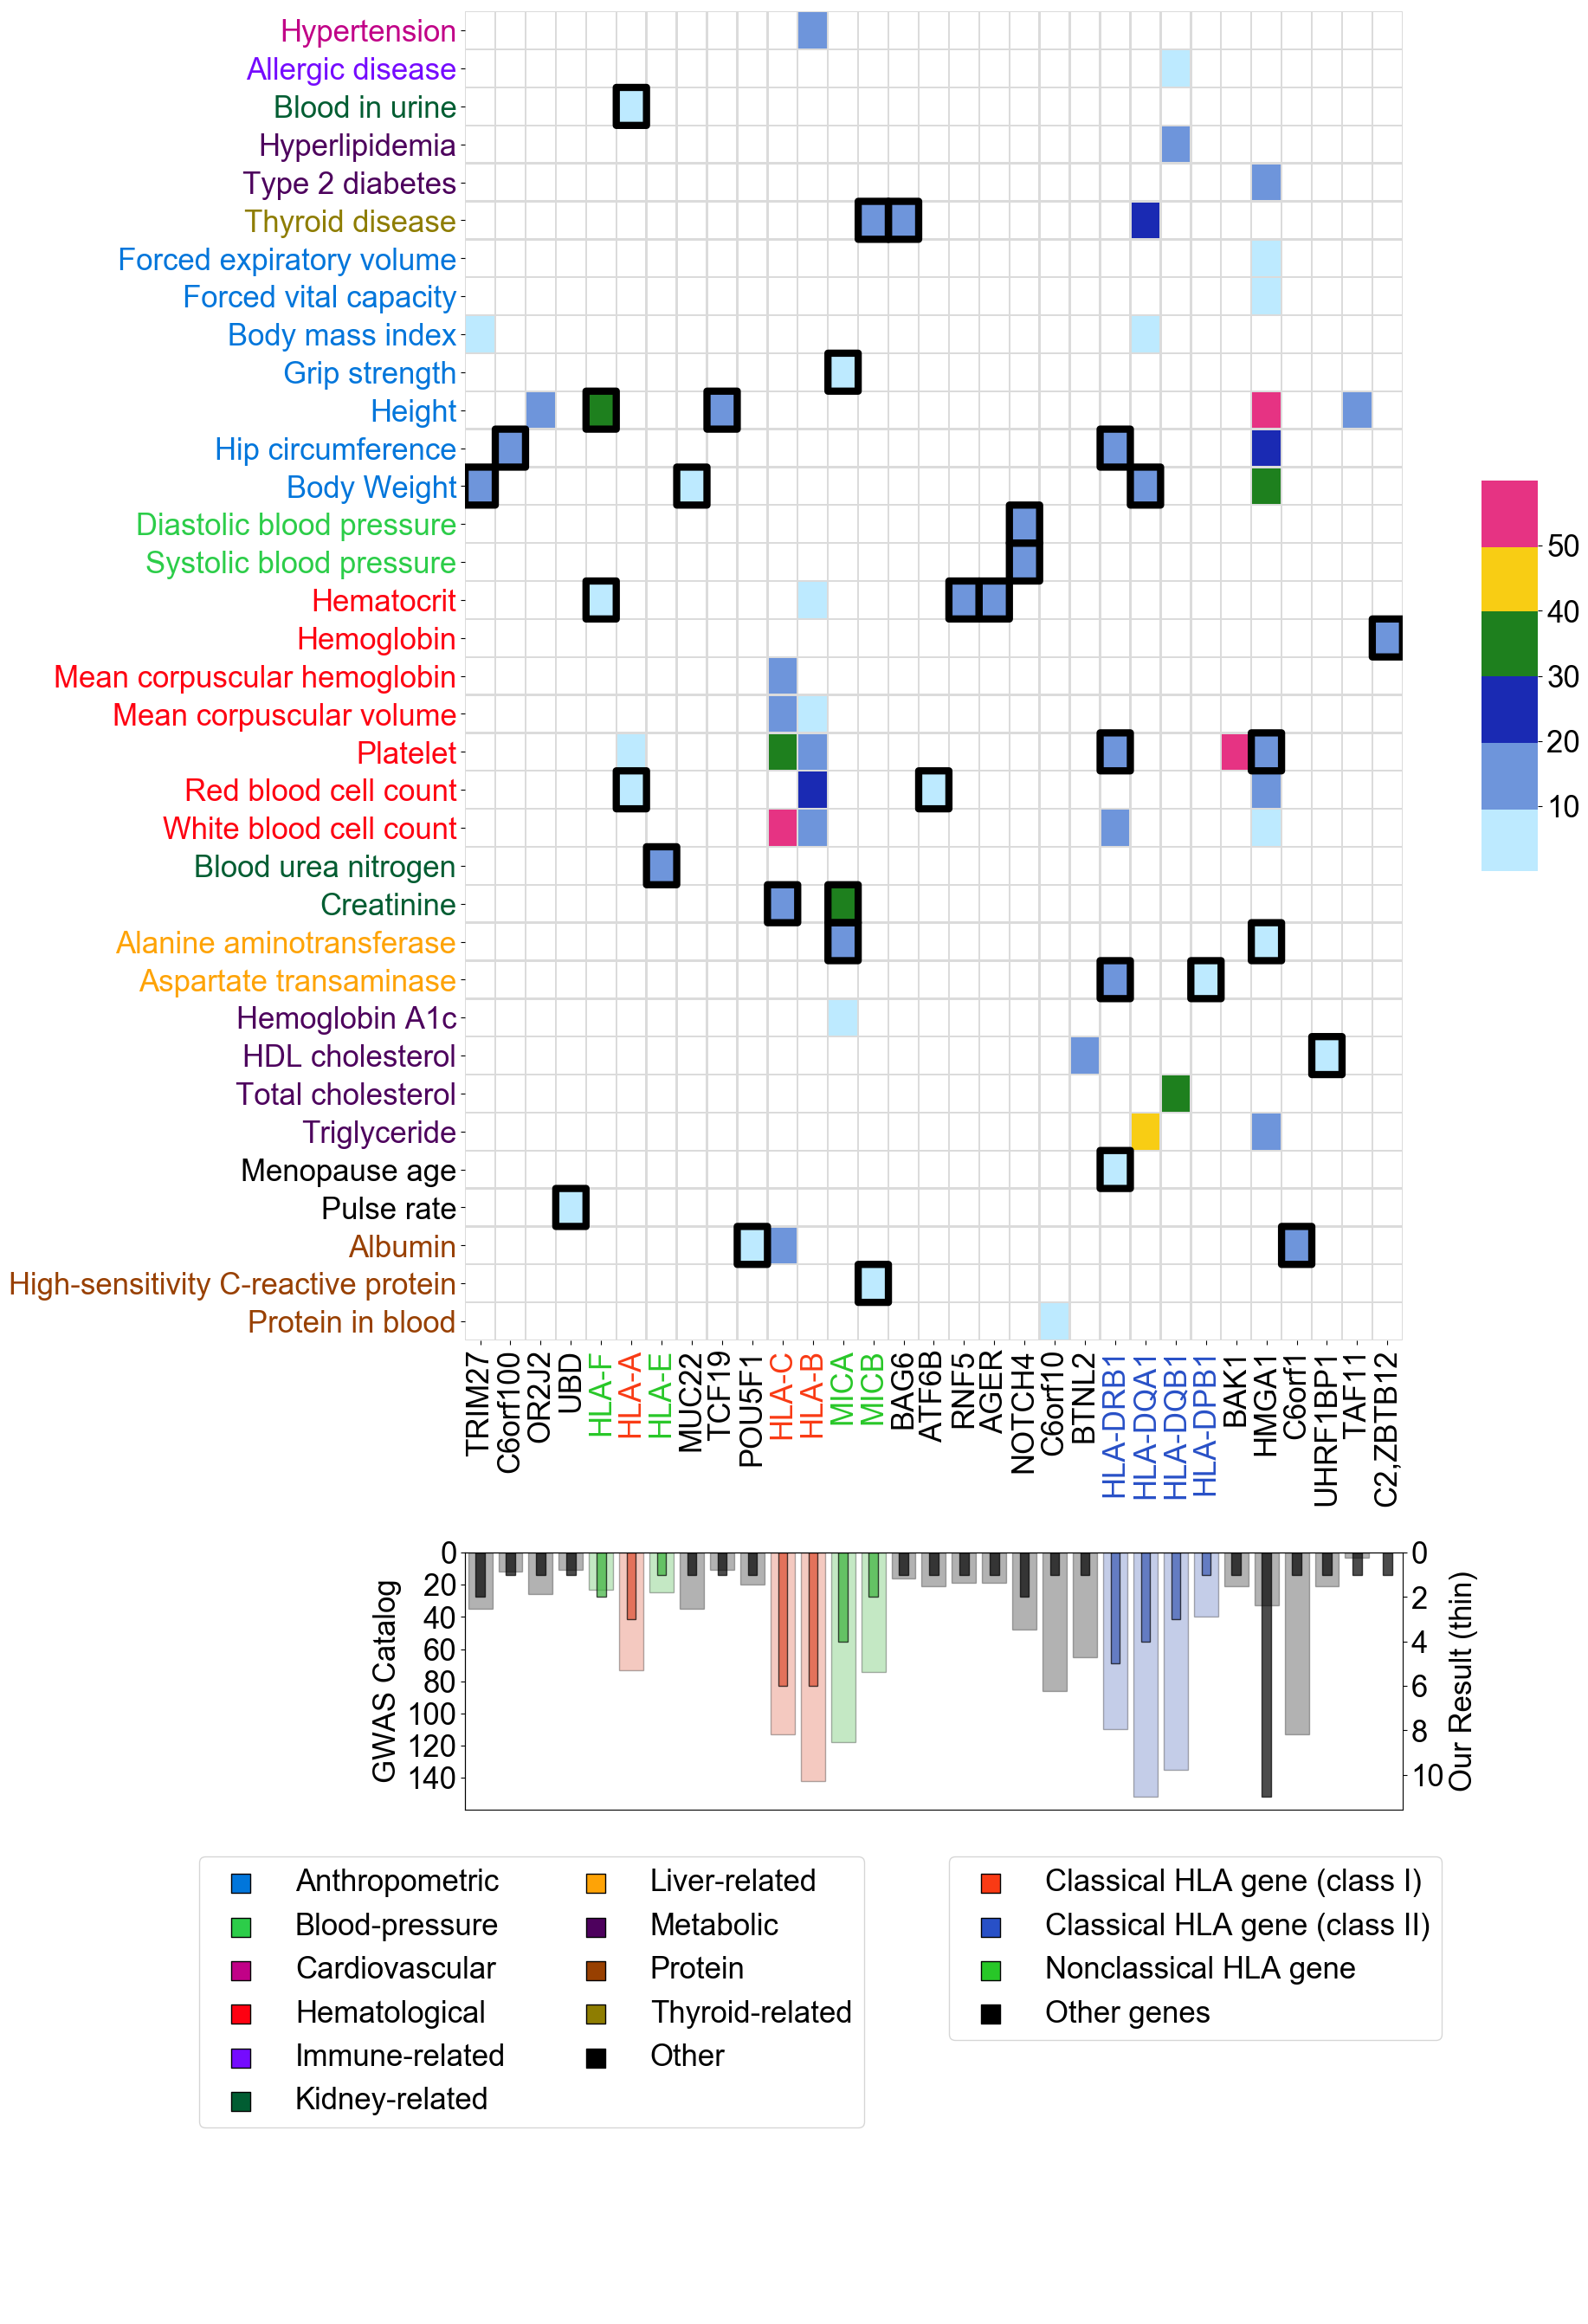

In [112]:
plt.rcParams["figure.figsize"] = (10,15)
plt.rcParams["font.size"] = 25
plt.rcParams['font.family']='Arial'

import matplotlib.gridspec as gridspec
import seaborn as sns

#fig = plt.figure(figsize=(10, 15+3)) 
fig = plt.figure(figsize=(13+1+3, 20+3+4+3+4)) 
gs=fig.add_gridspec(20+3+4+3+4,13+1+3)



#fig_barplot=fig.add_subplot(gs[20:24,0:13])

#gs = gridspec.GridSpec(3, 2, height_ratios=[5, 0.05, 1], width_ratios=[10,1]) 


fig_heatmap=fig.add_subplot(gs[0:20,0:14])
fig_heatmap_cmap=fig.add_subplot(gs[0+7:20-7, 14+1:14+1+1])


sns.heatmap(phewas_data_2d,
            ax=fig_heatmap,
            cmap=custom_cmap,
            vmin=0,
            vmax=60,
            xticklabels=True,
            linewidths=1,
            linecolor=np.array([220,220,220,256])/256,
            cbar_ax=fig_heatmap_cmap,
            cbar_kws={'fraction':0.1, "ticks":[10, 20, 30, 40, 50]},
            cbar=True,
            alpha=1,edgecolor='black')#,legend=None)
##fig.delaxes(fig_heatmap)
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator,MaxNLocator
#from matplotlib import ticker
#tick_locator = ticker.MaxNLocator(10)
#ax.xaxis.set_minor_locator(AutoMinorLocator())
#fig_barplot.minorticks_on()
#ax.xaxis.set_minor_locator(MultipleLocator(0.005))


#fig_heatmap.xaxis.set_major_locator(MaxNLocator(200))
fig_heatmap.set_ylabel('')
fig_heatmap.set_xlabel('')

for ticklabel in fig_heatmap.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))
fig_heatmap.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_heatmap.get_yticklabels()])

for ticklabel in fig_heatmap.xaxis.get_ticklabels():
    gene_name=ticklabel.get_text()
    ticklabel.set_color(gene_to_color_category(gene_name,'color'))


custom_cmap_white = ListedColormap([[1,1,1,0],
                                    [1,1,1,0],
                                    [1,1,1,0],
                                   ])    
#ax=sns.heatmap(phewas_data_2d_noveltycheck, ax=ax, cmap=custom_cmap_white, vmin=0, vmax=1, linecolor=None, cbar=False, alpha=0.7)#,legend=None)    
fig_heatmap.pcolor(phewas_data_2d_noveltycheck.values, cmap=custom_cmap_white, facecolor=None, edgecolors='black', linewidths=6)#, ax=ax)    
  
    
    
fig_barplot=fig.add_subplot(gs[20+3:20+3+4,0:14])    
sns.barplot(x='index',y='gene_name',ax=fig_barplot,data=phewas_data_2d_columns_catalog_all_count,
            edgecolor='black',
            palette=list(phewas_data_2d_columns_catalog_all_count['color'].values),alpha=0.3)    
fig_barplot.xaxis.set_visible(False)
fig_barplot.spines['right'].set_visible(False)
fig_barplot.spines['bottom'].set_visible(False)
fig_barplot.set_ylim(fig_barplot.get_ylim()[::-1])
fig_barplot.set_ylabel('GWAS Catalog')

fig_barplot2 = fig_barplot.twinx() 
sns.barplot(x='gene',y=0,data=phewas_data_2d_count,
            edgecolor='black',
            palette=list(phewas_data_2d_count['color'].values),alpha=0.7,ax=fig_barplot2)
fig_barplot2.set_ylim(fig_barplot2.get_ylim()[::-1])
fig_barplot2.set_ylabel('Our Result (thin)')


for bar in fig_barplot2.patches:
    newwidth=0.3
    
    x = bar.get_x()
    width = bar.get_width()
    centre = x + width/2.
    
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)

    
fig_legend=fig.add_subplot(gs[20+3+4+3:20+3+4+3+4, 0:14])    


category_color_df=pd.DataFrame([phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[phewas_data_2d.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(-0.3, 1.7),
    ncol=2
)

#print(category_color_df.head())
fig_legend.axis("off")
category_color_df=pd.DataFrame([phewas_data_2d.columns.map(lambda x: gene_to_color_category(x,'category')),
                            phewas_data_2d.columns.map(lambda x: gene_to_color_category(x,'color')),
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])
legend2=fig_legend.legend(
                    [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                    [row['category'] for (idx,row) in category_color_df.iterrows()],
                   loc='upper left',bbox_to_anchor=(0.5, 1.7)   #0.4
)
#print(category_color_df.head())
plt.gca().add_artist(legend1)

plt.style.use('default')
plt.savefig(data_out_pub_path+'phewas.png', bbox_inches='tight')

# H2

In [64]:
result_list=[]
for phenotype_name in binary_continuous_traits:
    #pheno[pheno['pheno']!=-9].to_csv(data_out_gcta_path+phenotype_name+'.phe',sep='\t',index=None,header=None)
    try:
        result=pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)
        result=result.astype(float)
        result=result.unstack().to_frame().sort_index(level=1).T
    except:
        print(phenotype_name,'pass')
        continue

    result.columns = result.columns.map(lambda x: '-'.join(x[::-1]))
    result.index=[phenotype_name]#[result_file.split('/')[-1].split('.')[0]]

    pheno=pd.read_csv(data_out_pheno_path+phenotype_name+'.phe',sep='\t',header=None,names=['FID','IID','pheno'])
    phenotype_type='binary' if len(pheno['pheno'][pheno['pheno']!=-9].value_counts())<3 else 'continuous'
        
    result['phenotype_type']=phenotype_type
    #print(result.columns)
    if phenotype_type=='binary':
        with open(data_out_pheno_path+phenotype_name+'.phe'+'.prev','r') as f:
            prev=float(f.read())
        #print('prev',prev)   
        result['prevalence']=prev
    result_list.append(result)  

freet4 pass
peripheral_vascular_diseases pass


In [66]:
from scipy.stats import norm
def h2_obs_to_liab(h2_obs, P, K):
    '''
    Converts heritability on the observed scale in an ascertained sample to heritability
    on the liability scale in the population.
    Parameters
    ----------
    h2_obs : float
        Heritability on the observed scale in an ascertained sample.
    P : float in (0,1)
        Prevalence of the phenotype in the sample.
    K : float in (0,1)
        Prevalence of the phenotype in the population.
    Returns
    -------
    h2_liab : float
        Heritability of liability in the population.
    '''
    if np.isnan(P) and np.isnan(K):
        return h2_obs
    if K <= 0 or K >= 1:
        raise ValueError('K must be in the range (0,1)')
    if P <= 0 or P >= 1:
        raise ValueError('P must be in the range (0,1)')

    thresh = norm.isf(K)
    conversion_factor = K ** 2 * \
        (1 - K) ** 2 / (P * (1 - P) * norm.pdf(thresh) ** 2)
    return h2_obs * conversion_factor

In [79]:
result_uni=pd.concat(result_list)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [80]:
result_uni['h2_liab']=result_uni.apply(lambda row: h2_obs_to_liab(row['V(G)/Vp-Estimate'],row['prevalence'],row['prevalence']) if row['phenotype_type']=='binary' else row['V(G)/Vp-Estimate'],axis=1)

In [81]:
#result=pd.read_csv('data/out_gcta/{}.HEreg'.format(phenotype_name),skiprows=[0,5,6,7,8],sep=r'\s+',index_col=0)
#result_concat

In [82]:
result_uni.to_csv('data/gcta_result_uni.tsv',sep='\t')

In [96]:
toplot

Index(['hematocrit', 'grip_strength', 'cataract', 'alt', 'total_bilirubin',
       'hysterectomy', 'bun', 'fracture', 'colon_polyps', 'menarche_onset_age',
       'albumin', 'bmi', 'ast', 'duodenal_ulcer', 'hip_circumference',
       'weight', 'creatinine', 'hdl_cholesterol', 'hba1c', 'mch', 'height',
       'small_baby', 'menopause_age', 'angina_pectoris_myocardial_infarction',
       't2_diabetes', 'rbc', 'protein_in_blood', 'FEV_over_FVC_predicted',
       'protein_in_urine', 'allergic_disease', 'sleep_duration',
       'bone_density_midshaft_sos', 'hypertension', 'mcv',
       'chronic_bronchitis', 'acute_liver_disease', 'total_cholesterol',
       'asthma', 'triglyceride', 'breast_cancer', 'insomnia', 'platelet',
       'wbc', 'liver_cancer', 'hyperlipidemia', 'colorectal_cancer',
       'stomach_cancer', 'thyroid_disease', 'blood_in_urine',
       'prostate_cancer', 'tuberculosis', 'cervical_cancer'],
      dtype='object')

In [103]:
#toplot['color']=
toplot.index.map(lambda x: phenotype_info.loc[x]['phenotype_category'])

Index(['Hematological QTL', 'Anthropometric QTL', 'Eye-related disease',
       'Liver-related QTL', 'Protein QTL', 'Other disease',
       'Kidney-related QTL', 'Orthopedic disorders', 'Other disease',
       'Other QTL', 'Protein QTL', 'Anthropometric QTL', 'Liver-related QTL',
       'Other disease', 'Anthropometric QTL', 'Anthropometric QTL',
       'Kidney-related QTL', 'Metabolic QTL', 'Metabolic QTL',
       'Hematological QTL', 'Anthropometric QTL', 'Other disease', 'Other QTL',
       'Cardiovascular disease', 'Metabolic disease', 'Hematological QTL',
       'Protein QTL', 'Anthropometric QTL', 'Other disease',
       'Immune-related disease', 'Other QTL', 'Anthropometric QTL',
       'Cardiovascular disease', 'Hematological QTL', 'Other disease',
       'Liver-related disease', 'Metabolic QTL', 'Immune-related disease',
       'Metabolic QTL', 'Cancer', 'Nervous system disease',
       'Hematological QTL', 'Hematological QTL', 'Cancer', 'Metabolic disease',
       'Cancer', '

In [105]:
#toplot['color']=
#toplot.index.map(lambda x: category_to_color_category(phenotype_info.loc[x]['phenotype_category'],'color'))

Index(['hematocrit', 'grip_strength', 'cataract', 'alt', 'total_bilirubin',
       'hysterectomy', 'bun', 'fracture', 'colon_polyps', 'menarche_onset_age',
       'albumin', 'bmi', 'ast', 'duodenal_ulcer', 'hip_circumference',
       'weight', 'creatinine', 'hdl_cholesterol', 'hba1c', 'mch', 'height',
       'small_baby', 'menopause_age', 'angina_pectoris_myocardial_infarction',
       't2_diabetes', 'rbc', 'protein_in_blood', 'FEV_over_FVC_predicted',
       'protein_in_urine', 'allergic_disease', 'sleep_duration',
       'bone_density_midshaft_sos', 'hypertension', 'mcv',
       'chronic_bronchitis', 'acute_liver_disease', 'total_cholesterol',
       'asthma', 'triglyceride', 'breast_cancer', 'insomnia', 'platelet',
       'wbc', 'liver_cancer', 'hyperlipidemia', 'colorectal_cancer',
       'stomach_cancer', 'thyroid_disease', 'blood_in_urine',
       'prostate_cancer', 'tuberculosis', 'cervical_cancer'],
      dtype='object')

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with 

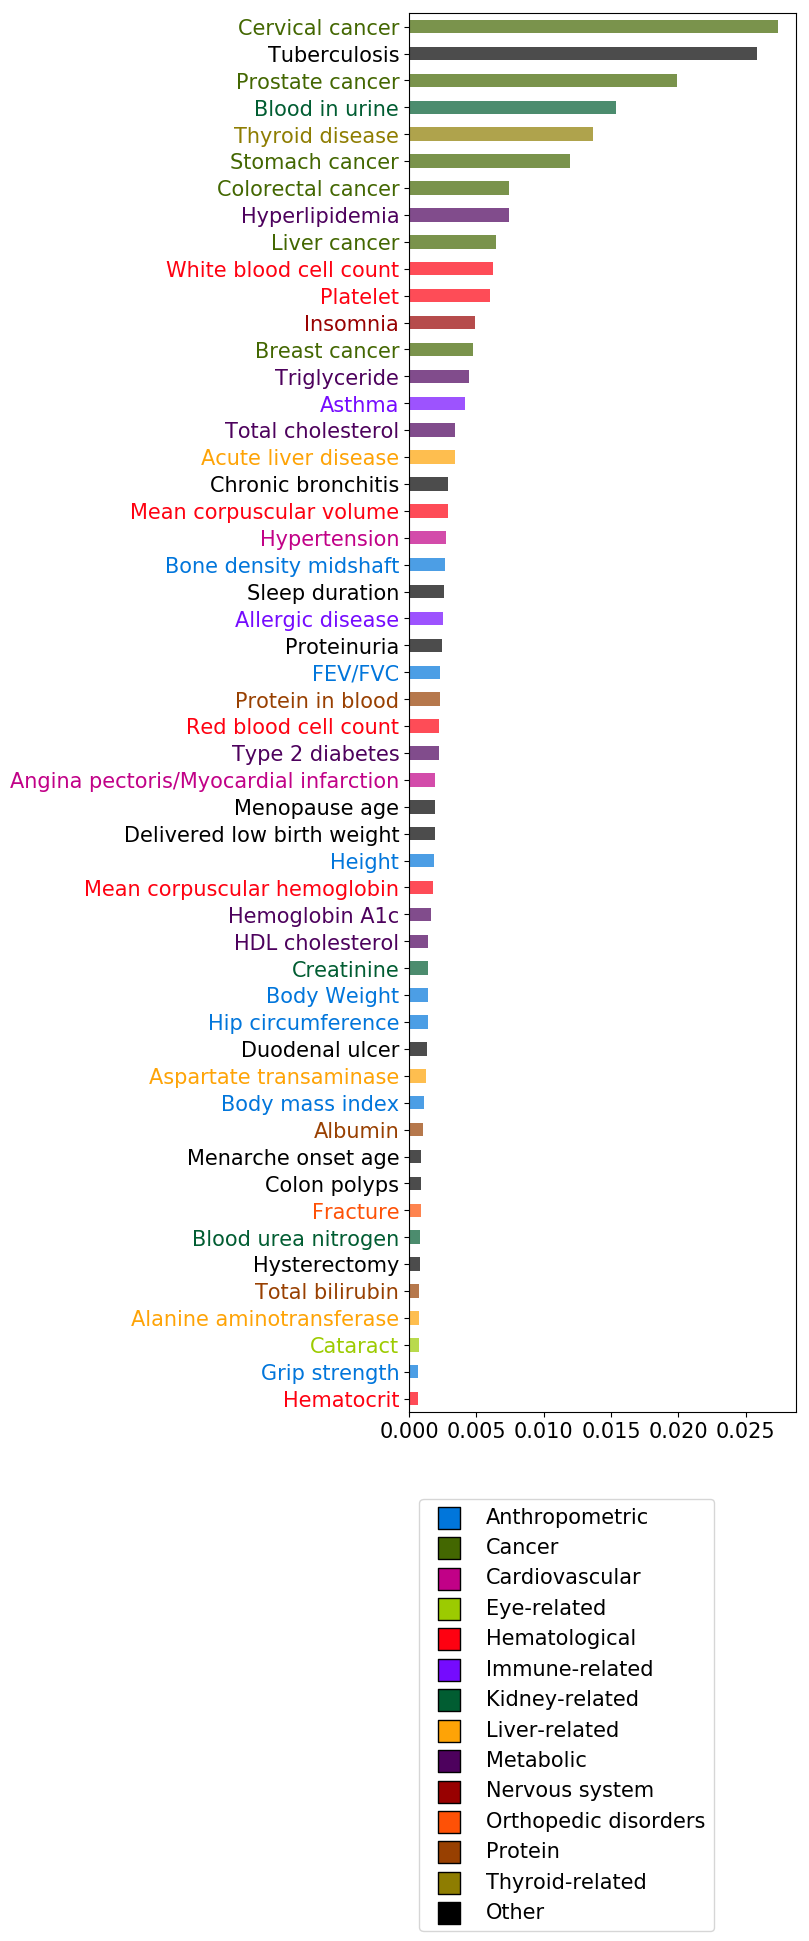

In [135]:
toplot=result_concat[result_concat['h2_liab']>0].copy()
toplot=toplot.sort_values('h2_liab',ascending=True).iloc[int(3*len(toplot)/10):]
toplot['color']=toplot.index.map(lambda x: category_to_color_category(phenotype_info.loc[x]['phenotype_category'],'color'))

#plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 15


fig = plt.figure(figsize=(5, 20)) 
gs=fig.add_gridspec(20+2,5)
#ax=fig.add_subplot(1,1,1)

fig_barplot=fig.add_subplot(gs[0:20,0:5])
"""
sns.barplot(
    x='h2_liab',
    y=0,
    data=toplot,
    ax=ax
)
"""
toplot['h2_liab'].plot.barh(linewidth=0.1,
                            colors=list(toplot['color'].values),
                            alpha=0.7,
                            ax=fig_barplot)

for ticklabel in fig_barplot.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))

fig_barplot.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_barplot.get_yticklabels()])






fig_legend=fig.add_subplot(gs[20:20+2, 0:5])   

category_color_df=pd.DataFrame([phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])

legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(0, 0.5)
)


fig_legend.axis("off")


plt.savefig(data_out_pub_path+'h2_uni.png', bbox_inches='tight')
#plt.savefig('figure_h2.svg', bbox_inches='tight')

# H2 bivar

In [83]:
rG_matrix_upper=np.zeros((len(result_uni),len(result_uni)))
rG_SE_matrix_upper=np.zeros((len(result_uni),len(result_uni)))

In [84]:
for i in range(0,len(result_uni)):
    for j in range(i+1,len(result_uni)):
        phenotype_name1=result_uni.iloc[i].name
        phenotype_name2=result_uni.iloc[j].name


        if os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.HEreg'):
            pass
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.HEreg'):
            (phenotype_name2,phenotype_name1)=phenotype_name1,phenotype_name2
        elif os.path.exists(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log'):
            #print(phenotype_name1,phenotype_name2,'missing')
            with open(data_out_gcta_path+phenotype_name2+'-'+phenotype_name1+'.log') as f:
                if 'no phenotype data is found' in f.read():
                    continue
        elif os.path.exists(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log'):
            #print(phenotype_name1,phenotype_name2,'missing')
            with open(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.log') as f:            
                if 'no phenotype data is found' in f.read():
                    continue            
        else:
            print(phenotype_name1,phenotype_name2)
            continue
            
        #result1=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name1),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        #result2=pd.read_csv(data_out_gcta_path+'{}.HEreg'.format(phenotype_name2),skiprows=[0,1,2,3,4,5],sep=r'\s+').set_index('Coefficient')#,skiprows=[0,1],sep=r'\s*')
        #pd.read_csv(data_out_gcta_path+phenotype_name1+'-'+phenotype_name2+'.phe',sep='\t',header=None)
        
        result_bivar=pd.read_csv(data_out_gcta_path+'{}-{}.HEreg'.format(phenotype_name1,phenotype_name2),skiprows=[0,1],sep=r'\s+').set_index('Coefficient')
        rG_matrix_upper[i][j]=result_bivar.loc['rG']['Estimate']
        rG_SE_matrix_upper[i][j]=result_bivar.loc['rG']['SE_OLS']        
        

In [136]:
def make_tri(mat):
    upper1=np.triu(mat,k=1)
    upper2=np.triu(mat.T,k=1) 
    
    ret=upper1+upper2 - np.where((upper1==upper2), upper1, 0)
    ret=np.triu(ret,k=1)
    return ret

In [137]:
rG_matrix=make_tri(rG_matrix_upper)
rG_abs_matrix=np.abs(rG_matrix)
rG_SE_matrix=make_tri(rG_SE_matrix_upper)
rG_Z_abs_matrix=np.abs(rG_matrix/rG_SE_matrix)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [138]:
rG_matrix_df=pd.DataFrame(rG_matrix,index=result_uni.index,columns=result_uni.index)
rG_abs_matrix_df=pd.DataFrame(rG_abs_matrix,index=result_uni.index,columns=result_uni.index)
#rG_Z_matrix_df=pd.DataFrame(rG_Z_matrix,index=result_uni.index,columns=result_uni.index)
rG_Z_abs_matrix_df=pd.DataFrame(rG_Z_abs_matrix,index=result_uni.index,columns=result_uni.index)
rG_SE_matrix_df=pd.DataFrame(rG_SE_matrix,index=result_uni.index,columns=result_uni.index)

In [139]:
edges=rG_matrix_df.mask(np.tril(np.ones(rG_matrix_df.shape)).astype(np.bool)).stack()
edges=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges.iteritems()],columns=['source','target','rG'])

In [140]:
edges2=rG_Z_abs_matrix_df.mask(np.tril(np.ones(rG_Z_abs_matrix_df.shape)).astype(np.bool)).stack()
edges2=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges2.iteritems()],columns=['source','target','Z_abs'])

In [141]:
edges3=rG_abs_matrix_df.mask(np.tril(np.ones(rG_abs_matrix_df.shape)).astype(np.bool)).stack()
edges3=pd.DataFrame([[edge[0][0],edge[0][1],edge[1]] for edge in edges3.iteritems()],columns=['source','target','rG_abs'])

In [142]:
edges=edges.merge(right=edges2,left_on=['source','target'],right_on=['source','target']).merge(right=edges3,left_on=['source','target'],right_on=['source','target'])

In [144]:
edges_filtered=edges.sort_values('Z_abs',ascending=False).iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]

In [145]:
edges_filtered.shape

(79, 5)

In [146]:
#edges_filtered=edges_filtered.sort_values('rG_abs',ascending=True)#.iloc[:int(len(edges)*0.03)]#edges[edges['value']>2]
edges_filtered=edges_filtered[edges_filtered['rG_abs']>0.3]
edges_filtered.shape

(77, 5)

In [147]:
groups=[]
for idx,row in edges_filtered.iterrows():
    try:
        group_index=[(row['source'] in groups[i] or row['target'] in groups[i]) for i in range(len(groups))].index(True)
        groups[group_index].add(row['source'])
        groups[group_index].add(row['target'])
    except:
        groups.append({row['source'],row['target']})

In [149]:
groups=sorted(groups,key=lambda x: len(x),reverse=True)

In [148]:
len(groups)

2

In [150]:
#phenotypes_par_filtered['group_id']=
edges_filtered['group_id']=[np.argmax([False]+[row['source'] in group for group in groups]) for idx,row in edges_filtered.iterrows()]

In [151]:
import networkx as nx

In [152]:
edges_filtered[edges_filtered['group_id']==2]

,source,target,rG,Z_abs,rG_abs,group_id


In [153]:
edges_filtered_filtered=edges_filtered[edges_filtered['group_id']==1]
#edges_filtered_filtered=edges_filtered

G_temp=nx.convert_matrix.from_pandas_edgelist(edges_filtered_filtered,edge_attr=['rG','rG_abs','Z_abs'])

#per_bp_var_temp=per_bp_var.copy()
#per_bp_var_temp.index=per_bp_var_temp.index.map(lambda x:description_to_short(code_to_description(x),'pub',2))
nx.set_node_attributes(G_temp,dict([(node,pd.Series(result_uni['V(G)/Vp-Estimate'].loc[node]).iloc[0]) for node in list(G_temp.nodes)]),'heritability')
#nx.set_node_attributes(G_temp,dict([(node,node) for node in list(G.nodes)]),'label')

In [482]:
#G=nx.relabel_nodes(G_temp,lambda x: description_to_short(code_to_description(x),'pub',2))

G=G_temp.copy()#nx.relabel_nodes(G_temp,lambda x:description_to_short(code_to_description(x),'abbr_pub_ori','correlation'))
#pos = nx.kamada_kawai_layout(G,weight='Z_abs')
pos = nx.spring_layout(G,weight='Z_abs')

In [483]:
plt.rcParams["figure.figsize"] = (30,30)
plt.rcParams["font.size"] = 10
#sns.heatmap(rG_matrix_df, annot=True,cmap=plt.get_cmap('PiYG'),center=0,vmin=-1,vmax=1)

In [484]:
import random

angle_map=lambda x: (np.arctan(x[1]/x[0])+(np.pi if x[0]<0 else 0)+2*np.pi)%(2*np.pi)

def draw_arc(a,b):

    center=(a+b)/2+(1 if random.random()>0.5 else -1)*np.array([(b-a)[1],-(b-a)[0]])*random.uniform(np.sqrt(3)/2,2)

    radius=np.sqrt(np.power(b-center,2).sum())

    a_theta=angle_map(a-center)#arctan_norm((a-center)[1]/(a-center)[0])
    b_theta=angle_map(b-center)
    
    if abs(b_theta-a_theta)>np.pi:
        if a_theta>b_theta:
            a_theta=a_theta-2*np.pi
        else:
            b_theta=b_theta-2*np.pi
            
    try:
        return [center+radius*np.array([np.cos(theta),np.sin(theta)]) for theta in np.arange(min(a_theta,b_theta),max(a_theta,b_theta),abs(b_theta-a_theta)/100)]
    except:
        print('error')
        return [a,b]

#draw_arc(np.array((0,1)),np.array((1,0)))

In [485]:

phenotype_info.loc[node_df.index]['phenotype_category']

total_cholesterol                     Metabolic QTL
triglyceride                          Metabolic QTL
height                           Anthropometric QTL
platelet                          Hematological QTL
hyperlipidemia                    Metabolic disease
creatinine                       Kidney-related QTL
wbc                               Hematological QTL
rbc                               Hematological QTL
thyroid_disease             Thyroid-related disease
mcv                               Hematological QTL
hypertension                 Cardiovascular disease
hip_circumference                Anthropometric QTL
weight                           Anthropometric QTL
mch                               Hematological QTL
bun                              Kidney-related QTL
hdl_cholesterol                       Metabolic QTL
diastolic_blood_pressure         Blood-pressure QTL
bmi                              Anthropometric QTL
hba1c                                 Metabolic QTL
hemoglobin  

In [486]:
#[i[0] for i in edge_df['source_xy'].values]

In [487]:
scatter_hue.max(),scatter_hue.min()

(0.0062347999999999995, 0.000573956)

In [488]:
edge_df[edge_color].abs().max(),edge_df[edge_color].max()

(1.09429, 1.09429)

<Figure size 1500x2000 with 0 Axes>

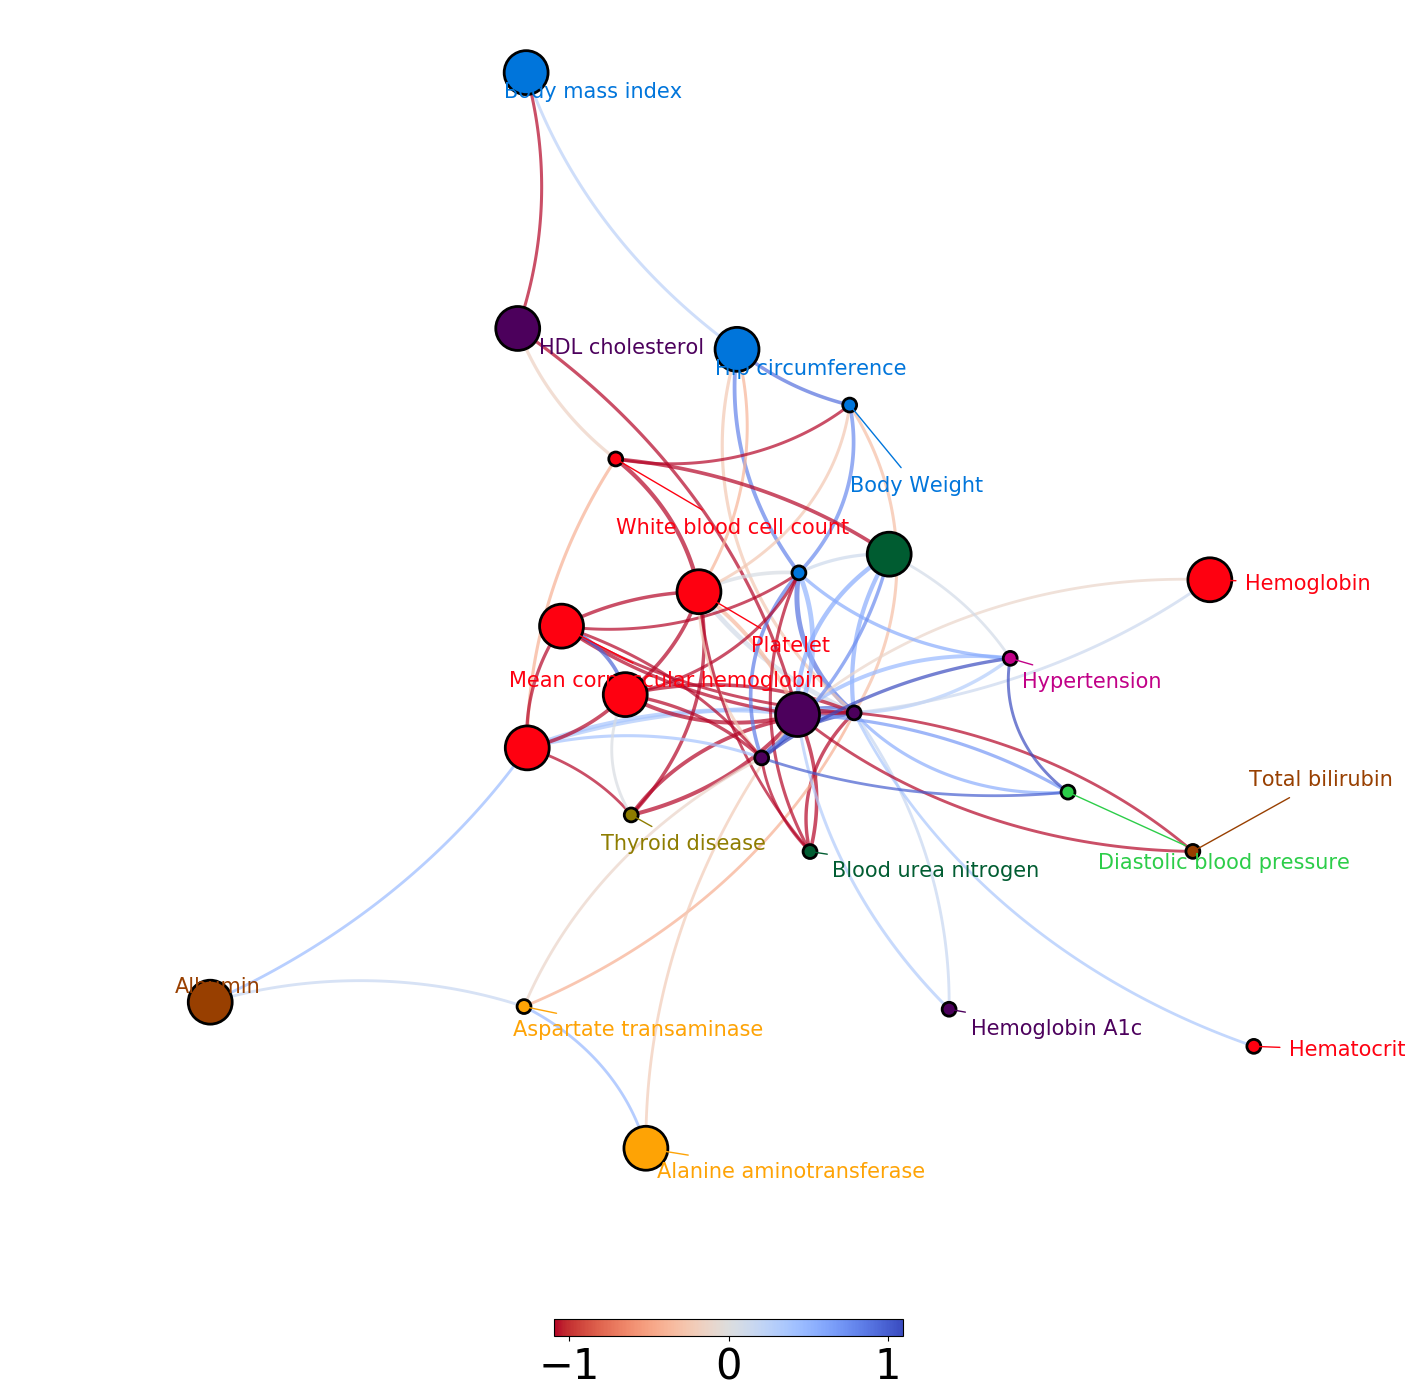

In [489]:
node_color='heritability'
node_size='heritability'

edge_width='Z_abs'
edge_color='rG'

from matplotlib.collections import LineCollection

plt.rcParams["figure.figsize"] = (15,20)
plt.rcParams["font.size"] = 30


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
"""
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
"""   

#,[
scatter_x=[i[0] for i in edge_df['source_xy'].values]
scatter_y=[i[1] for i in edge_df['source_xy'].values]
scatter_hue=edge_df[edge_color].copy()
scatter_hue.iloc[[0,1]]=[-scatter_hue.abs().max(),scatter_hue.abs().max()]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.coolwarm.reversed())
        
plt.clf()
  

fig, ax = plt.subplots()

plt.colorbar(points,orientation="horizontal",pad=0.07,shrink=0.3)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=2+3*line_collection_linewidths

line_collection_colors=np.array([plt.cm.coolwarm.reversed()(row[edge_color],alpha=0.7) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=ax.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
plt.scatter(x=scatter_x,
            y=scatter_y,
            c=list(phenotype_info.loc[node_df.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values),
            alpha=1,
            s=scatter_size,
            edgecolor='black',
            linewidth=2,
            sizes=(100,1000))#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    #description_short=idx
    
    s=phenotype_info.loc[idx]['phenotype_name_publication']
    color=category_to_color_category(phenotype_info.loc[idx]['phenotype_category'],'color')
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            plt.annotate(s,
                         xy=xy,
                         color=color,
                         xytext=xytext,
                         arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0",ls=None,color=color),
                         bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0), ec="None", lw=0.3),
                         size=15)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True)
plt.axis('off')

#plt.show()
plt.savefig(data_out_pub_path+'h2_bivar.svg', bbox_inches='tight')


/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with 

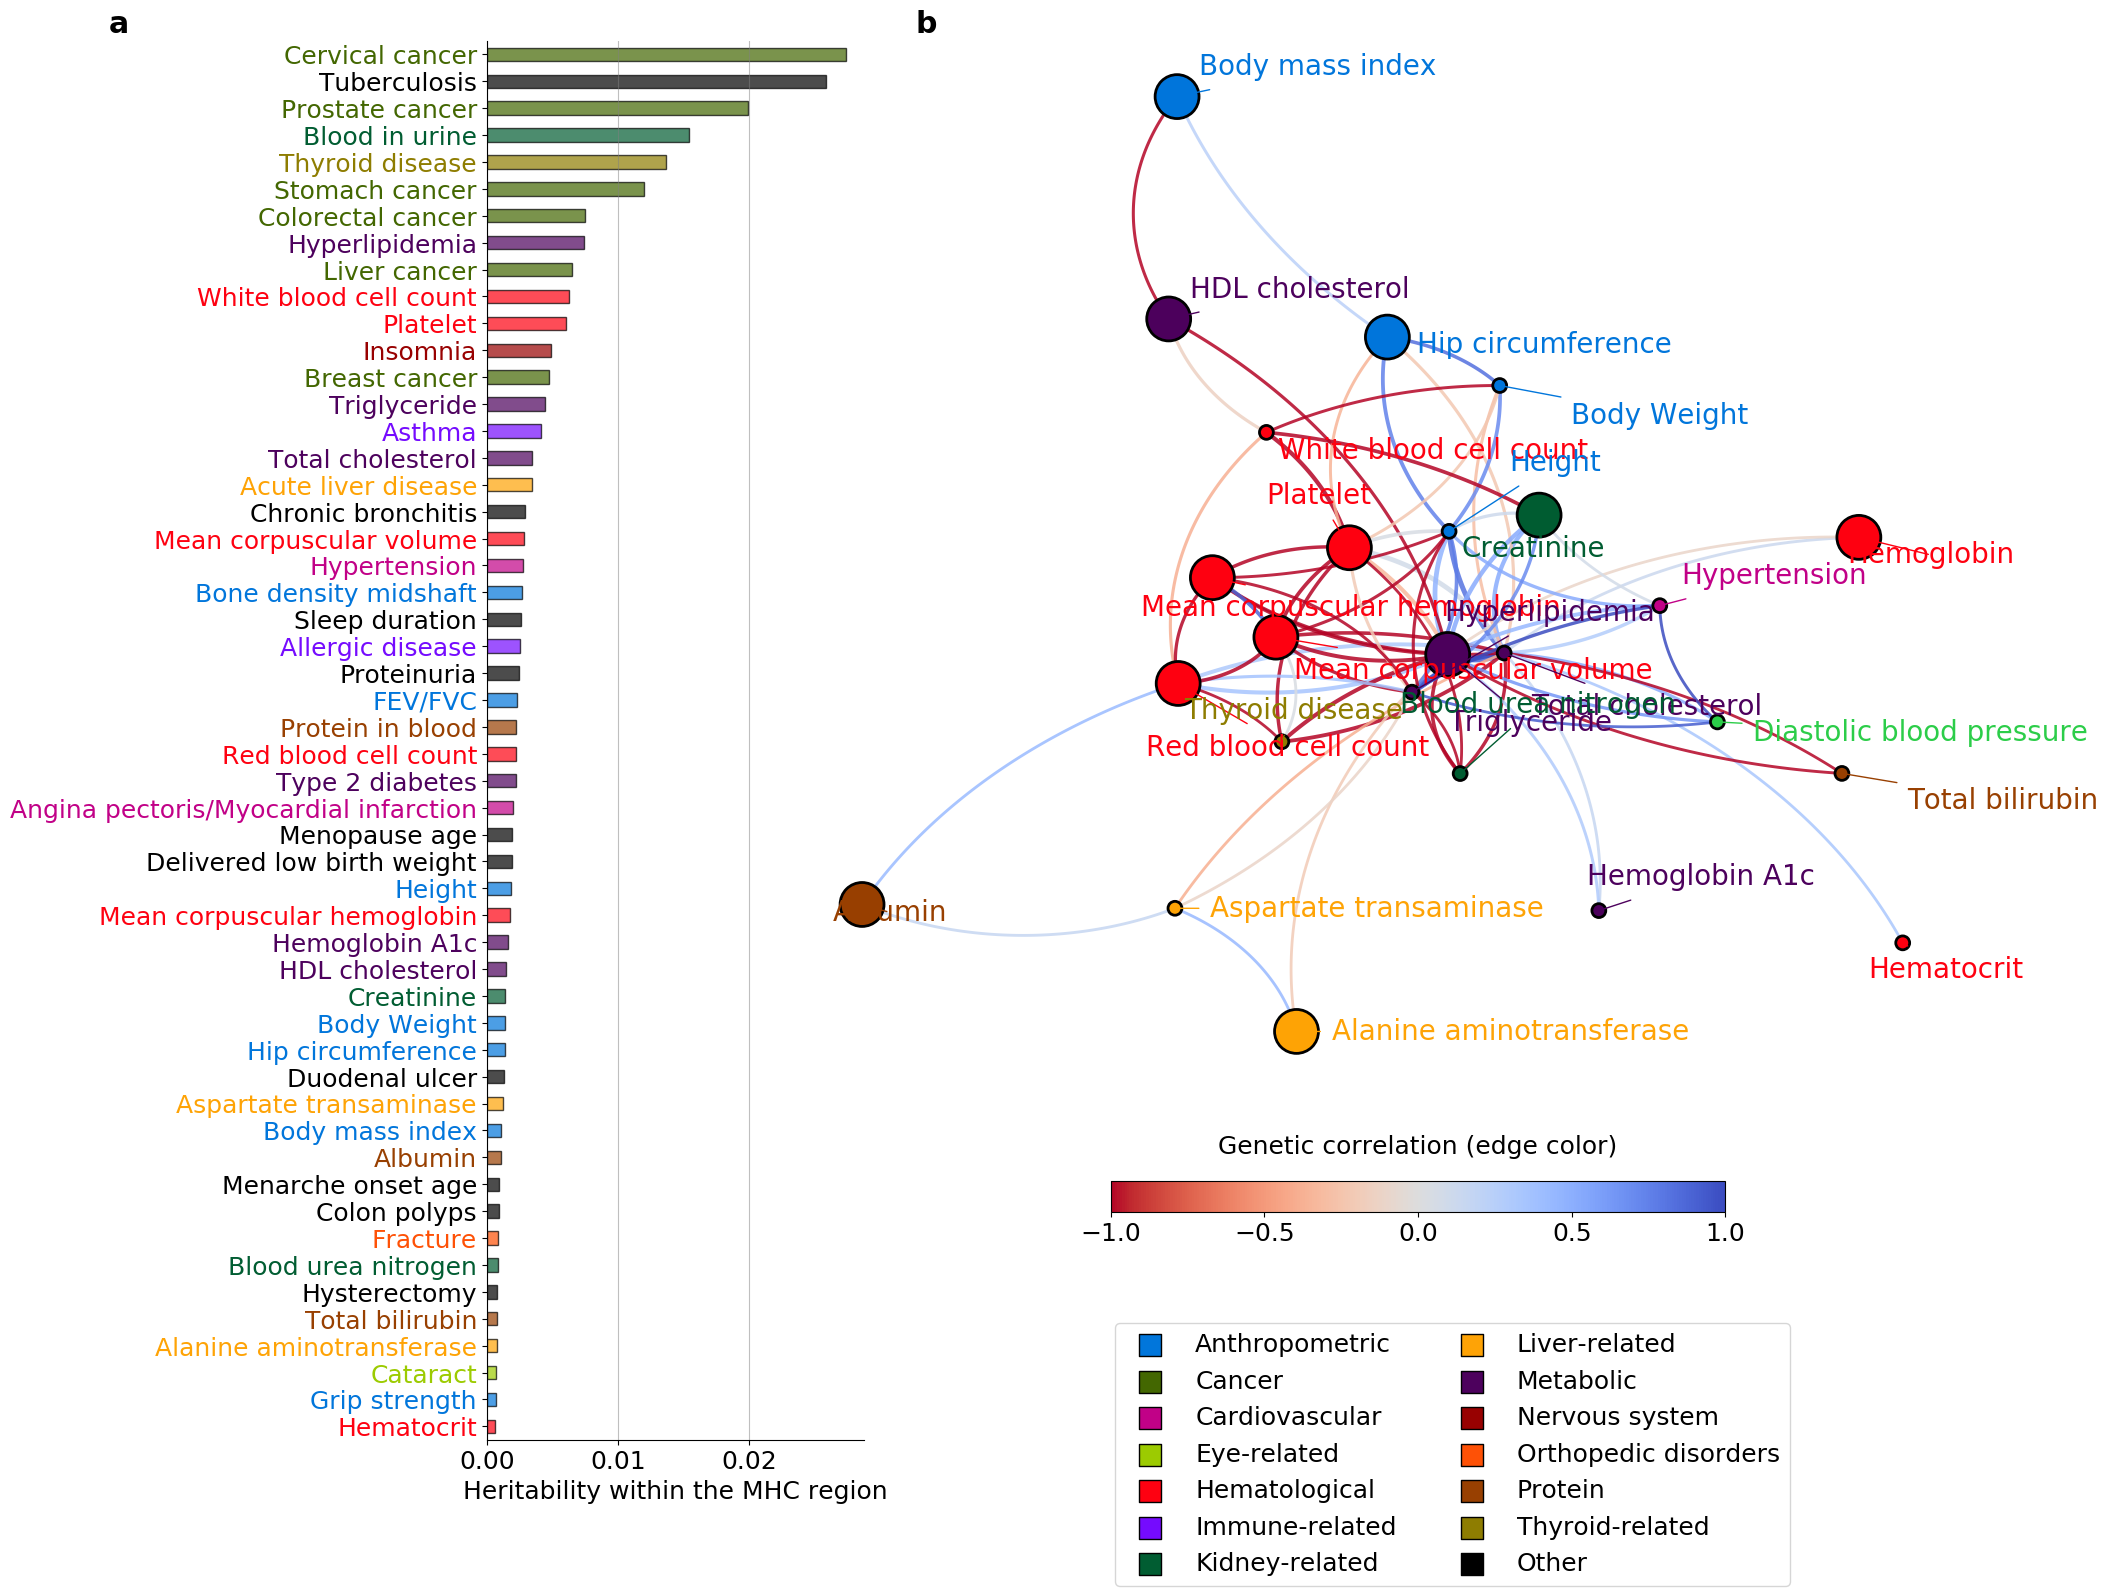

In [491]:
fig = plt.figure(figsize=(5+15, 20)) 
gs=fig.add_gridspec(20+2,5+15)


toplot=result_concat[result_concat['h2_liab']>0].copy()
toplot=toplot.sort_values('h2_liab',ascending=True).iloc[int(3*len(toplot)/10):]
toplot['color']=toplot.index.map(lambda x: category_to_color_category(phenotype_info.loc[x]['phenotype_category'],'color'))

#plt.rcParams["figure.figsize"] = (5,30)
plt.rcParams["font.size"] = 18



#ax=fig.add_subplot(1,1,1)

fig_barplot=fig.add_subplot(gs[0:20,0:5])
"""
sns.barplot(
    x='h2_liab',
    y=0,
    data=toplot,
    ax=ax
)
"""
toplot['h2_liab'].plot.barh(linewidth=1,
                            colors=list(toplot['color'].values),
                            alpha=0.7,
                            edgecolor='black',
                            ax=fig_barplot)

for ticklabel in fig_barplot.yaxis.get_ticklabels():
    phenotype_name=ticklabel.get_text()
    phenotype_category=phenotype_info.loc[phenotype_name]['phenotype_category']
    ticklabel.set_color(category_to_color_category(phenotype_category,'color'))

fig_barplot.set_yticklabels([phenotype_info.loc[item.get_text()]['phenotype_name_publication'] for item in fig_barplot.get_yticklabels()])

#fig_barplot.set_minor_locator(MultipleLocator(0.005))

fig_barplot.set_xlabel('Heritability within the MHC region')

sns.despine(top=True,right=True,left=False,bottom=False,ax=fig_barplot)

#fig_barplot.yaxis.set_minor_locator(MultipleLocator(0.005))

fig_barplot.grid(True, which='major', axis='x', color='gray', alpha=0.5, linestyle='-')
#fig_barplot.grid(True, which='minor', axis='x', color='gray', alpha=0.5, linestyle='-')

#from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator

#ax.xaxis.set_minor_locator(AutoMinorLocator())
#fig_barplot.minorticks_on()
#ax.xaxis.set_minor_locator(MultipleLocator(0.005))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#ax.tick_params(which='minor', length=4, color='r')

#fig_barplot.grid(True, which='major', axis='x', color='gray', alpha=0.5, linestyle='-')
#fig_barplot.grid(True, which='minor', axis='x', color='gray', alpha=0.5, linestyle='-')


fig_legend=fig.add_subplot(gs[15+3:15+3+2, 12:12+5])   

category_color_df=pd.DataFrame([phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'category')).values,
                                phenotype_info.loc[toplot.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values,
                ],index=['category','color']).T
category_color_df=category_color_df[~category_color_df.duplicated('category')]
category_color_df=category_color_df.sort_values('category')
category_color_df=pd.concat([category_color_df[~category_color_df['category'].str.contains('Other')],
               category_color_df[category_color_df['category'].str.contains('Other')]])

legend1=fig_legend.legend(
                        [plt.scatter([],[], marker = 's', s=250, c=row['color'], edgecolor='black', label = row['category']) for (idx,row) in category_color_df.iterrows()],
                        [row['category'] for (idx,row) in category_color_df.iterrows()],
                        loc='upper left',bbox_to_anchor=(0, 0)
)


fig_legend.axis("off")

fig_legend.legend(ncol=2)










fig_network=fig.add_subplot(gs[0:15, 5-1:5+15-1])


node_color='heritability'
node_size='heritability'

edge_width='Z_abs'
edge_color='rG'

from matplotlib.collections import LineCollection


#node initialization
node_df=pd.DataFrame([(pos[node]) for node in G.nodes],index=G.nodes,columns=['x','y'])
for node in G.nodes:
    for idx,value in G.nodes[node].items():
        node_df.loc[node,idx]=value

#edge initialization
edge_df=pd.DataFrame([(pos[edge[0]],pos[edge[1]]) for edge in G.edges],index=G.edges,columns=['source_xy','target_xy'])
for edge in G.edges:
    for idx,value in G.edges[edge].items():
        edge_df.loc[edge,idx]=value

############## Drawing ##############
        
# Draw colorbar
"""
scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
points=plt.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.PiYG)
        
plt.clf()
"""   

#fig_colorbar=fig.add_subplot(gs[14+1:14+1+2, 12:12+5])   
#,[
#scatter_x=[i[0] for i in edge_df['source_xy'].values]
#scatter_y=[i[1] for i in edge_df['source_xy'].values]
#scatter_hue=edge_df[edge_color].copy()
#scatter_hue.iloc[[0,1]]=[-scatter_hue.abs().max(),scatter_hue.abs().max()]
#points=fig_colorbar.scatter(x=scatter_x,y=scatter_y,c=scatter_hue,cmap=plt.cm.coolwarm.reversed())
        
#plt.clf()
#fig_colorbar.remove()
#fig_colorbar.axis("off")
#fig_colorbar.set_visible(False)


fig_colorbar=fig.add_subplot(gs[14+2:14+2+1, 7:7+10])   
#ax = fig_colorbar.add_axes([0.05, 0.80, 0.9, 0.1])
fig_colorbar.axis('off')

fig_colorbar_ax=mpl.colorbar.make_axes(fig_colorbar, location=None, orientation='horizontal', fraction=0.8, shrink=0.8, aspect=20)

cb = mpl.colorbar.ColorbarBase(fig_colorbar_ax[0], orientation='horizontal', 
                               cmap=plt.cm.coolwarm.reversed(),
                               norm=mpl.colors.Normalize(-1, 1),  # vmax and vmin
                               ticks=[-1, -0.5, 0, 0.5, 1]
                              )

cb.set_label('Genetic correlation (edge color)',labelpad=-80)
#cb.set_label('Genetic correlation (edge color)',y=-100)
#fig_colorbar_ax[0].legend(loc='upper left',bbox_to_anchor=(0, 1))
#fig, ax = plt.subplots()
"""
This solution can be also used to draw the colorbar independenly of the content of ax. Just set fraction = .05.

Code

import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

fraction = 1  # .05

norm = mpl.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='Blues'),
            ax=ax, pad=.05, extend='both', fraction=fraction)
"""
#import matplotlib as mpl
#plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1),cmap=plt.cm.coolwarm.reversed()),
#             orientation="horizontal",fraction=1,aspect=30, ax=fig_colorbar)   

# Draw edges


#line_collection_xy=[[row['source_xy'],(row['source_xy']+row['target_xy'])/2+(0.1,0.1),row['target_xy']] for idx,row in edge_df.iterrows()]
line_collection_xy=[draw_arc(row['source_xy'],row['target_xy']) for idx,row in edge_df.iterrows()]

line_collection_linewidths=np.array([row[edge_width] for idx,row in edge_df.iterrows()])
line_collection_linewidths=(line_collection_linewidths-line_collection_linewidths.min())/(line_collection_linewidths.max()-line_collection_linewidths.min())
line_collection_linewidths=2+3*line_collection_linewidths

line_collection_colors=np.array([plt.cm.coolwarm.reversed()(row[edge_color],alpha=0.85) for idx,row in edge_df.iterrows()])

line_collection=LineCollection(line_collection_xy,zorder=-5,colors=line_collection_colors,linewidths=line_collection_linewidths)
l_c=fig_network.add_collection(line_collection)

# Draw nodes

scatter_x=node_df['x']
scatter_y=node_df['y']
scatter_hue=node_df[node_color]
#scatter_hue=np.array([plt.cm.rainbow(row[node_color],alpha=0.7) for idx,row in node_df.iterrows()])
#
scatter_size=np.exp(node_df[node_size])
fig_network.scatter(x=scatter_x,
            y=scatter_y,
            c=list(phenotype_info.loc[node_df.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values),
            alpha=1,
            s=scatter_size,
            edgecolor='black',
            linewidth=2,
            sizes=(100,1000))#,color='white')#,edgecolor='black')


############## Annotation ##############


r_sample=np.arange(0.05,0.15,0.01)
theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

np.random.shuffle(theta_sample)
move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
#print(move_sample)
#print(move_sample)
text_plotted=pd.DataFrame([])
for idx,row in node_df.sort_values('y',ascending=False).iterrows():
    #description_short=idx
    
    s=phenotype_info.loc[idx]['phenotype_name_publication']
    color=category_to_color_category(phenotype_info.loc[idx]['phenotype_category'],'color')
    xy=np.array([row['x'], row['y']])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    
    for move in move_sample:
        xytext=xy+move
        if np.all(move==move_sample[-1]) or text_plotted.shape[0]==0 or (((node_df['x']-xytext[0])**2+(node_df['y']-xytext[1])**2)<1).sum()==0 or (((text_plotted['x']-xytext[0])**2+0.5*(text_plotted['y']-xytext[1])**2)<0.05).sum()==0:
            fig_network.annotate(s,
                         xy=xy,
                         color=color,
                         xytext=xytext,
                         arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0",ls=None,color=color),
                         bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,0), ec="None", lw=0.3),
                         size=20)
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

sns.despine(top=True,right=True,left=True,bottom=True,ax=fig_network)
fig_network.axis('off')


fig_barplot.set_title('a', x=-1.0, fontweight='bold', loc='left')
fig_network.set_title('b', x=+0.1, fontweight='bold', loc='left')





plt.savefig(data_out_pub_path+'h2_uni_bivar.png', bbox_inches='tight')
plt.savefig(data_out_pub_path+'h2_uni_bivar.svg', bbox_inches='tight')
#plt.savefig('figure_h2.svg', bbox_inches='tight')

In [359]:
for i in zip([1,2,3],[4,5,6]):
    print(i)

(1, 4)
(2, 5)
(3, 6)


In [302]:
fig_colorbar_ax

(<matplotlib.axes._axes.Axes at 0x7f0062abb358>,
 {'orientation': 'vertical', 'ticklocation': 'right'})

In [295]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

inset_axes()

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=plt.cm.coolwarm.reversed(),
                               norm=mpl.colors.Normalize(-1, 1),  # vmax and vmin
                               label='Genetic correlation (edge color)',
                               ticks=[-1, -0.5, 0, 0.5, 1])

SyntaxError: unexpected EOF while parsing (<ipython-input-295-ed6e69d17cc2>, line 10)

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with 

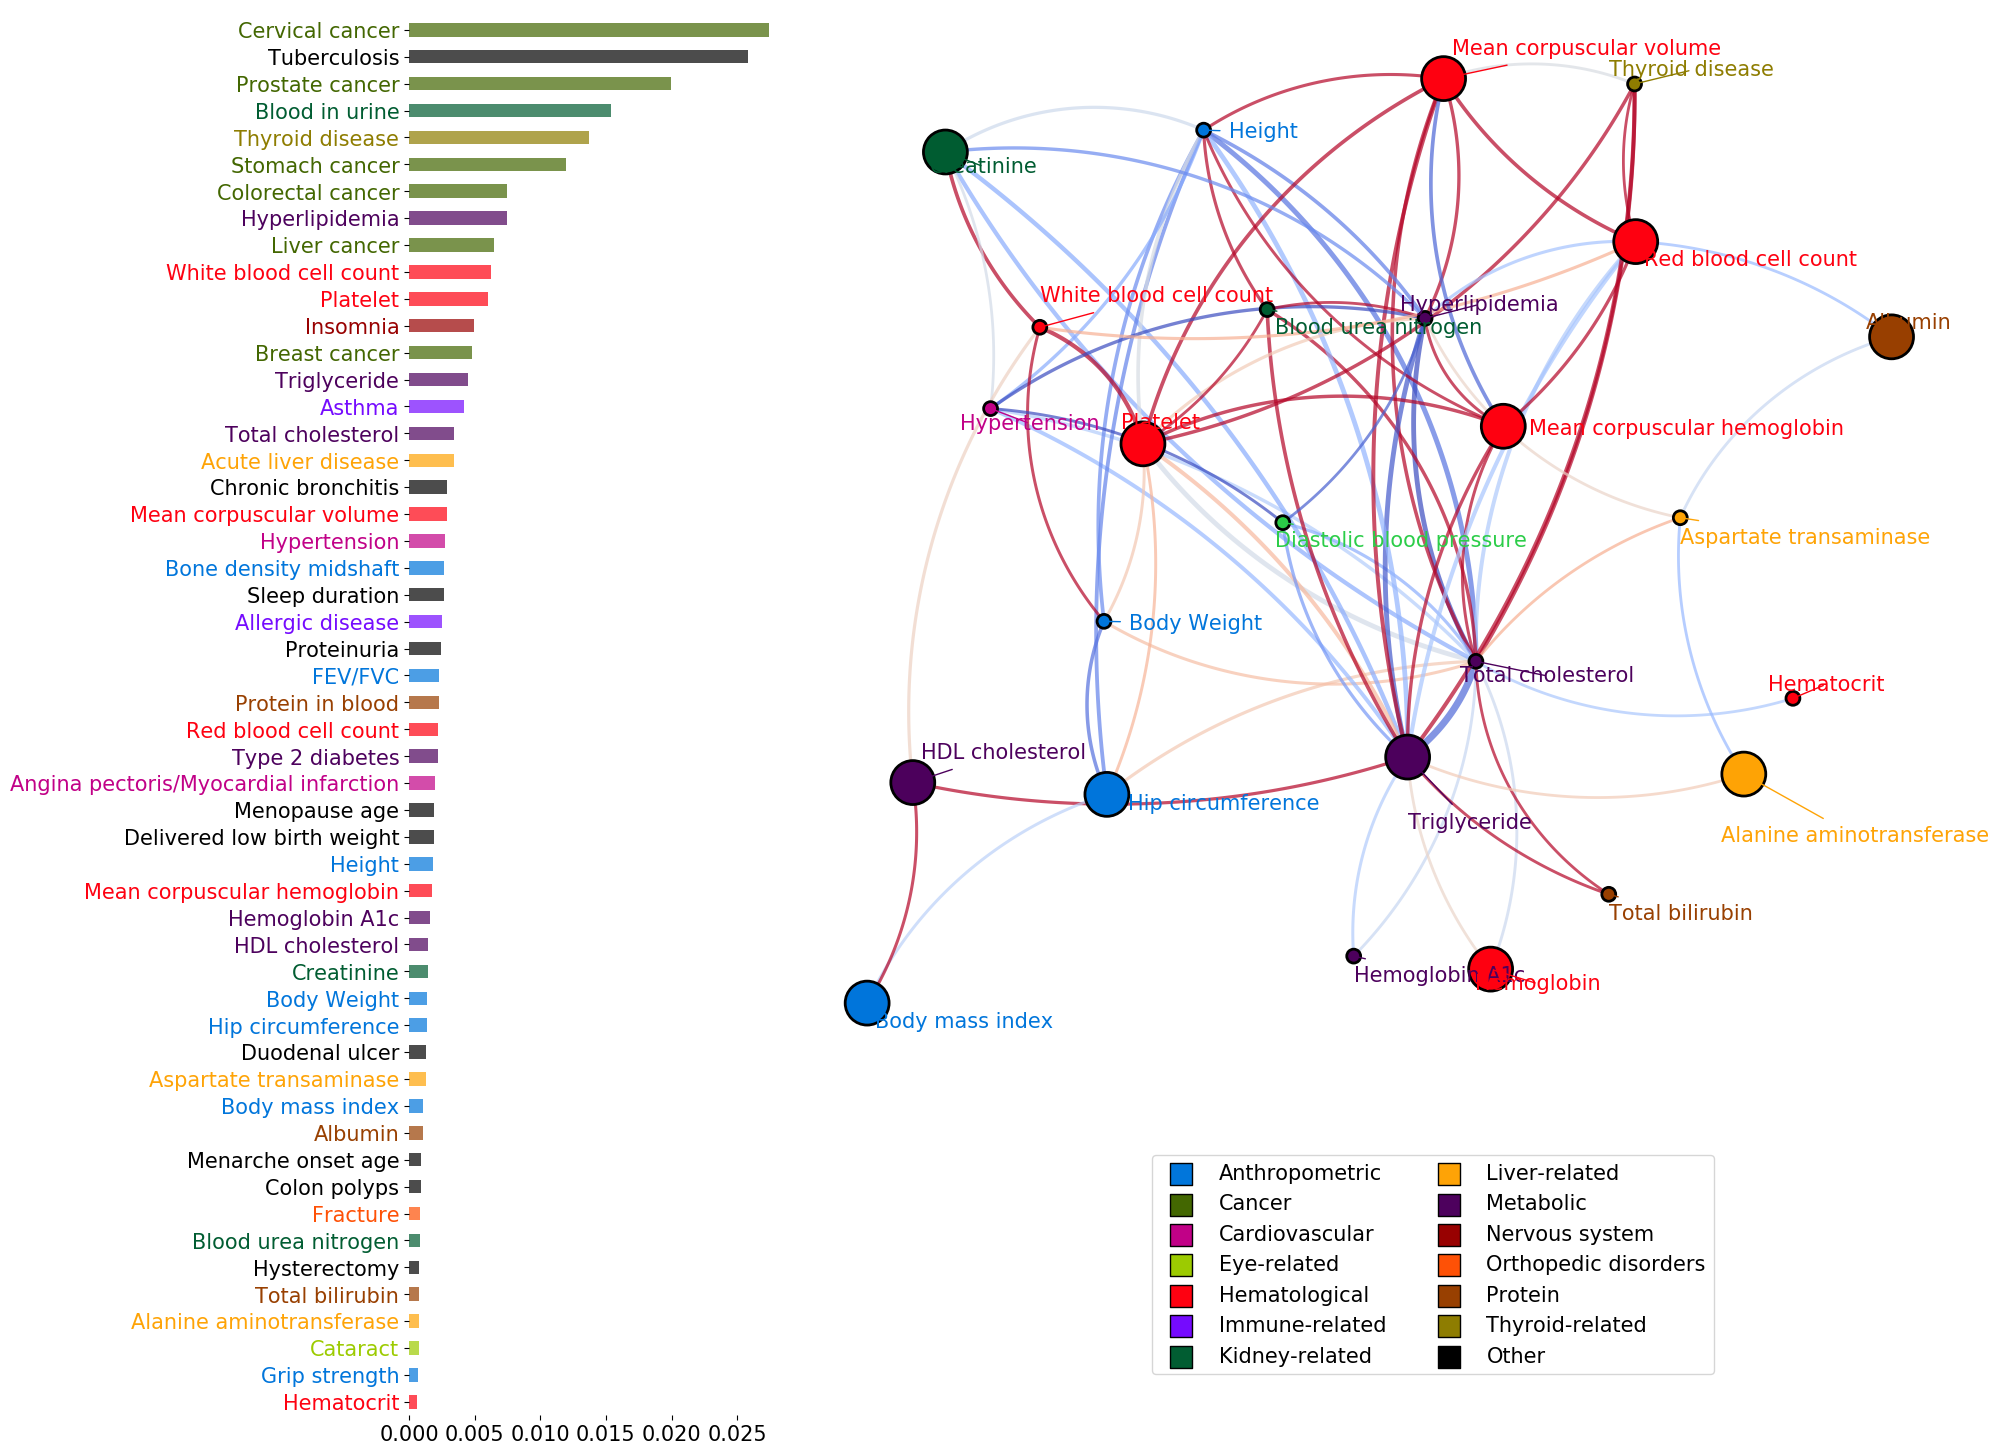

In [175]:
list(phenotype_info.loc[node_df.index]['phenotype_category'].map(lambda x: category_to_color_category(x,'color')).values)

[array([0.296875  , 0.        , 0.359375  , 0.99609375]),
 array([0.296875  , 0.        , 0.359375  , 0.99609375]),
 array([0.        , 0.45703125, 0.859375  , 0.99609375]),
 array([0.99609375, 0.        , 0.0625    , 0.99609375]),
 array([0.296875  , 0.        , 0.359375  , 0.99609375]),
 array([0.        , 0.359375  , 0.19140625, 0.99609375]),
 array([0.99609375, 0.        , 0.0625    , 0.99609375]),
 array([0.99609375, 0.        , 0.0625    , 0.99609375]),
 array([0.55859375, 0.484375  , 0.        , 0.99609375]),
 array([0.99609375, 0.        , 0.0625    , 0.99609375]),
 array([0.7578125 , 0.        , 0.53125   , 0.99609375]),
 array([0.        , 0.45703125, 0.859375  , 0.99609375]),
 array([0.        , 0.45703125, 0.859375  , 0.99609375]),
 array([0.99609375, 0.        , 0.0625    , 0.99609375]),
 array([0.        , 0.359375  , 0.19140625, 0.99609375]),
 array([0.296875  , 0.        , 0.359375  , 0.99609375]),
 array([0.16796875, 0.8046875 , 0.28125   , 0.99609375]),
 array([0.    